# Automatic Music Composition with RNN
# Uses Keras interface,  TensorFlow backend and Music21
# Dataset:  Guitar God **Steve Vai's** music scores. 

This notebook pretends to create a model  for automatic music compostion. 
It will create a song based on the training input. For training we have used  **Steve Vai's songs** in midi format. Music21 will be used to convert midi files into training data. Actually, there are two models, one for the notes and other for the duration of each note. 

We will use a RNN, LSTM, with timestep = 7 and around 30K sequences of training data.

In the experiment, we will provide the first 7 notes of a well known Steve Vai's song: "For the love of god", and we will check what the model composes with those 7 notes as an input. We have the original song to compare.

There are many challenges here, but some of them for further work:
* The guitar scores have melodies and solos. The solos' parts have notes of very short duration, played very fast and very repetitive. Future work, will build models for melody and soloing - however there is not a clear boundary when building a solo or when building a melody
* The possible notes are given by the key of the song. If we are in Em, there are a set of allowed notes and other not allowed. The model is trained with the whole Vai's scores, who are in many different keys, hence keeping the tune is up for the model to have learned. Future work will explore working with intervals instead of notes themselves.
* Keeping a melody must remain estable in duration with no ups and down in duration, I will explore ways to have a melody built-up through the model.





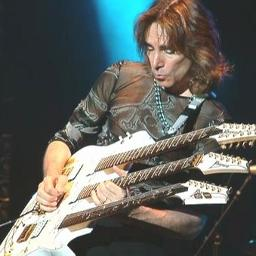

In [1]:
from IPython.display import Image
Image(filename='stevevai.jpg') 

In [2]:
!pip install music21



    100% |████████████████████████████████| 18.5MB 2.8MB/s eta 0:00:011
  Running setup.py bdist_wheel for music21 ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/7b/21/95/d396f231b8095f30aba2a1fbffbc2411fb22eb4e611ddbed57
Successfully built music21
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install keras

You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [37]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import music21	
	
#tf.enable_eager_execution()
print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

tf.logging.set_verbosity(tf.logging.INFO)


TensorFlow version: 1.12.0
Eager execution: False


In [2]:
import glob
from music21 import converter, instrument, note, chord, midi
 
#midi_path= "ForTheLoveofGod.mid"
midi_path= "MIDI/*.mid"

notes = []
chords = []
duration = []
notes_to_parse = None

for file in glob.glob(midi_path):
    print("--------------------------------------------")
    print("Reading midi file: ", file)
#Read MIDI

    mf = midi.MidiFile()
    mf.open(file)
    mf.read()
    mf.close()
    
#List song parts
    midix = midi.translate.midiFileToStream(mf)
    partStream = midix.parts.stream()
    print("List of instruments found on MIDI file: ",file)
    for p in partStream:
        aux = p
        print (p.partName)

#info about the song

    parts = midix.parts.stream()

    print("Elements of the MIDI: ",midix.elements)
    print("Parts of the MIDI: ",parts)
    print("LEN parts:", len(parts))

#extracting the melody part 

    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes flat structure
        notes_to_parse = midi.flat.notes

#parse notes,duration an chords

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
            duration.append(str(element.duration.quarterLength))
        elif isinstance(element, chord.Chord):
            chords.append('.'.join(str(n) for n in element.normalOrder))

    #print("DURATION:", duration)
    #print("CHORD: ",chords)
    print("Total ",len(notes)," NOTES.")

        



--------------------------------------------
Reading midi file:  MIDI/LuckyCharms.mid
List of instruments found on MIDI file:  MIDI/LuckyCharms.mid
None
None
None
None
Sitar
None
None
Guitar
Brass
Brass
None
Flute
Celesta
None
Bagpipes
Elements of the MIDI:  (<music21.stream.Part 0x7f365b46c470>, <music21.stream.Part 0x7f365ae3f630>, <music21.stream.Part 0x7f365ad76160>, <music21.stream.Part 0x7f365ad37e80>, <music21.stream.Part 0x7f365aad4cc0>, <music21.stream.Part 0x7f365a9ed630>, <music21.stream.Part 0x7f365a83aa20>, <music21.stream.Part 0x7f365ac87be0>, <music21.stream.Part 0x7f365a99afd0>, <music21.stream.Part 0x7f365a726978>, <music21.stream.Part 0x7f365a4c2e80>, <music21.stream.Part 0x7f365a401f28>, <music21.stream.Part 0x7f365a42f8d0>, <music21.stream.Part 0x7f365a436ac8>, <music21.stream.Part 0x7f365a43f278>)
Parts of the MIDI:  <music21.stream.Score 0x7f365b46c780>
LEN parts: 15
Total  204  NOTES.
--------------------------------------------
Reading midi file:  MIDI/FireGarde

List of instruments found on MIDI file:  MIDI/RescueMeOrBuryMe.mid
None
None
None
Elements of the MIDI:  (<music21.stream.Part 0x7f365662e400>, <music21.stream.Part 0x7f3656833fd0>, <music21.stream.Part 0x7f365917b470>)
Parts of the MIDI:  <music21.stream.Score 0x7f3654e44978>
LEN parts: 3
Total  7648  NOTES.
--------------------------------------------
Reading midi file:  MIDI/MysteriousMurderOfChristianTierasLover.mid
List of instruments found on MIDI file:  MIDI/MysteriousMurderOfChristianTierasLover.mid
None
None
Piano
Elements of the MIDI:  (<music21.stream.Part 0x7f3658784dd8>, <music21.stream.Part 0x7f3654879fd0>, <music21.stream.Part 0x7f3658777668>)
Parts of the MIDI:  <music21.stream.Score 0x7f3658784a90>
LEN parts: 3
Total  7982  NOTES.
--------------------------------------------
Reading midi file:  MIDI/AchingHunger.mid
List of instruments found on MIDI file:  MIDI/AchingHunger.mid
None
None
None
None
None
None
None
None
Elements of the MIDI:  (<music21.stream.Part 0x7f365

List of instruments found on MIDI file:  MIDI/Bangkok.mid
None
None
None
None
None
None
None
None
None
Sitar
Guitar
Piano
Piano
Piano
Voice
Voice
Flute
Flute
Flute
Flute
Brass
Brass
Brass
Harp
Marimba
Celesta
Timpani
StringInstrument
StringInstrument
Elements of the MIDI:  (<music21.stream.Part 0x7f364fe83710>, <music21.stream.Part 0x7f36590312b0>, <music21.stream.Part 0x7f3659031cf8>, <music21.stream.Part 0x7f3659029860>, <music21.stream.Part 0x7f36587e69e8>, <music21.stream.Part 0x7f36562ff4a8>, <music21.stream.Part 0x7f36591bbe48>, <music21.stream.Part 0x7f36590d5828>, <music21.stream.Part 0x7f3657f9d6d8>, <music21.stream.Part 0x7f3655e03e48>, <music21.stream.Part 0x7f365486cbe0>, <music21.stream.Part 0x7f3659c9a438>, <music21.stream.Part 0x7f3658bdf358>, <music21.stream.Part 0x7f3656115358>, <music21.stream.Part 0x7f365637fda0>, <music21.stream.Part 0x7f3655c6fef0>, <music21.stream.Part 0x7f3655c72940>, <music21.stream.Part 0x7f365b85d748>, <music21.stream.Part 0x7f36559ef978>, <mu

List of instruments found on MIDI file:  MIDI/GreasyKidsStuff.mid
None
None
None
None
None
None
None
Piano
StringInstrument
Elements of the MIDI:  (<music21.stream.Part 0x7f3657f8bef0>, <music21.stream.Part 0x7f365884f208>, <music21.stream.Part 0x7f3655d63080>, <music21.stream.Part 0x7f3657cdaf98>, <music21.stream.Part 0x7f3659245ef0>, <music21.stream.Part 0x7f365844e898>, <music21.stream.Part 0x7f3659264d30>, <music21.stream.Part 0x7f3656ee6748>, <music21.stream.Part 0x7f3656b2a9e8>)
Parts of the MIDI:  <music21.stream.Score 0x7f3658321780>
LEN parts: 9
Total  20768  NOTES.
--------------------------------------------
Reading midi file:  MIDI/WereNotGonnaProtest.mid
List of instruments found on MIDI file:  MIDI/WereNotGonnaProtest.mid
None
None
None
None
None
None
StringInstrument
Brass
Flute
Clarinet
Piano
Electric Bass
Piano
Elements of the MIDI:  (<music21.stream.Part 0x7f3659076828>, <music21.stream.Part 0x7f3657f89e10>, <music21.stream.Part 0x7f3659a80e80>, <music21.stream.Part 0

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


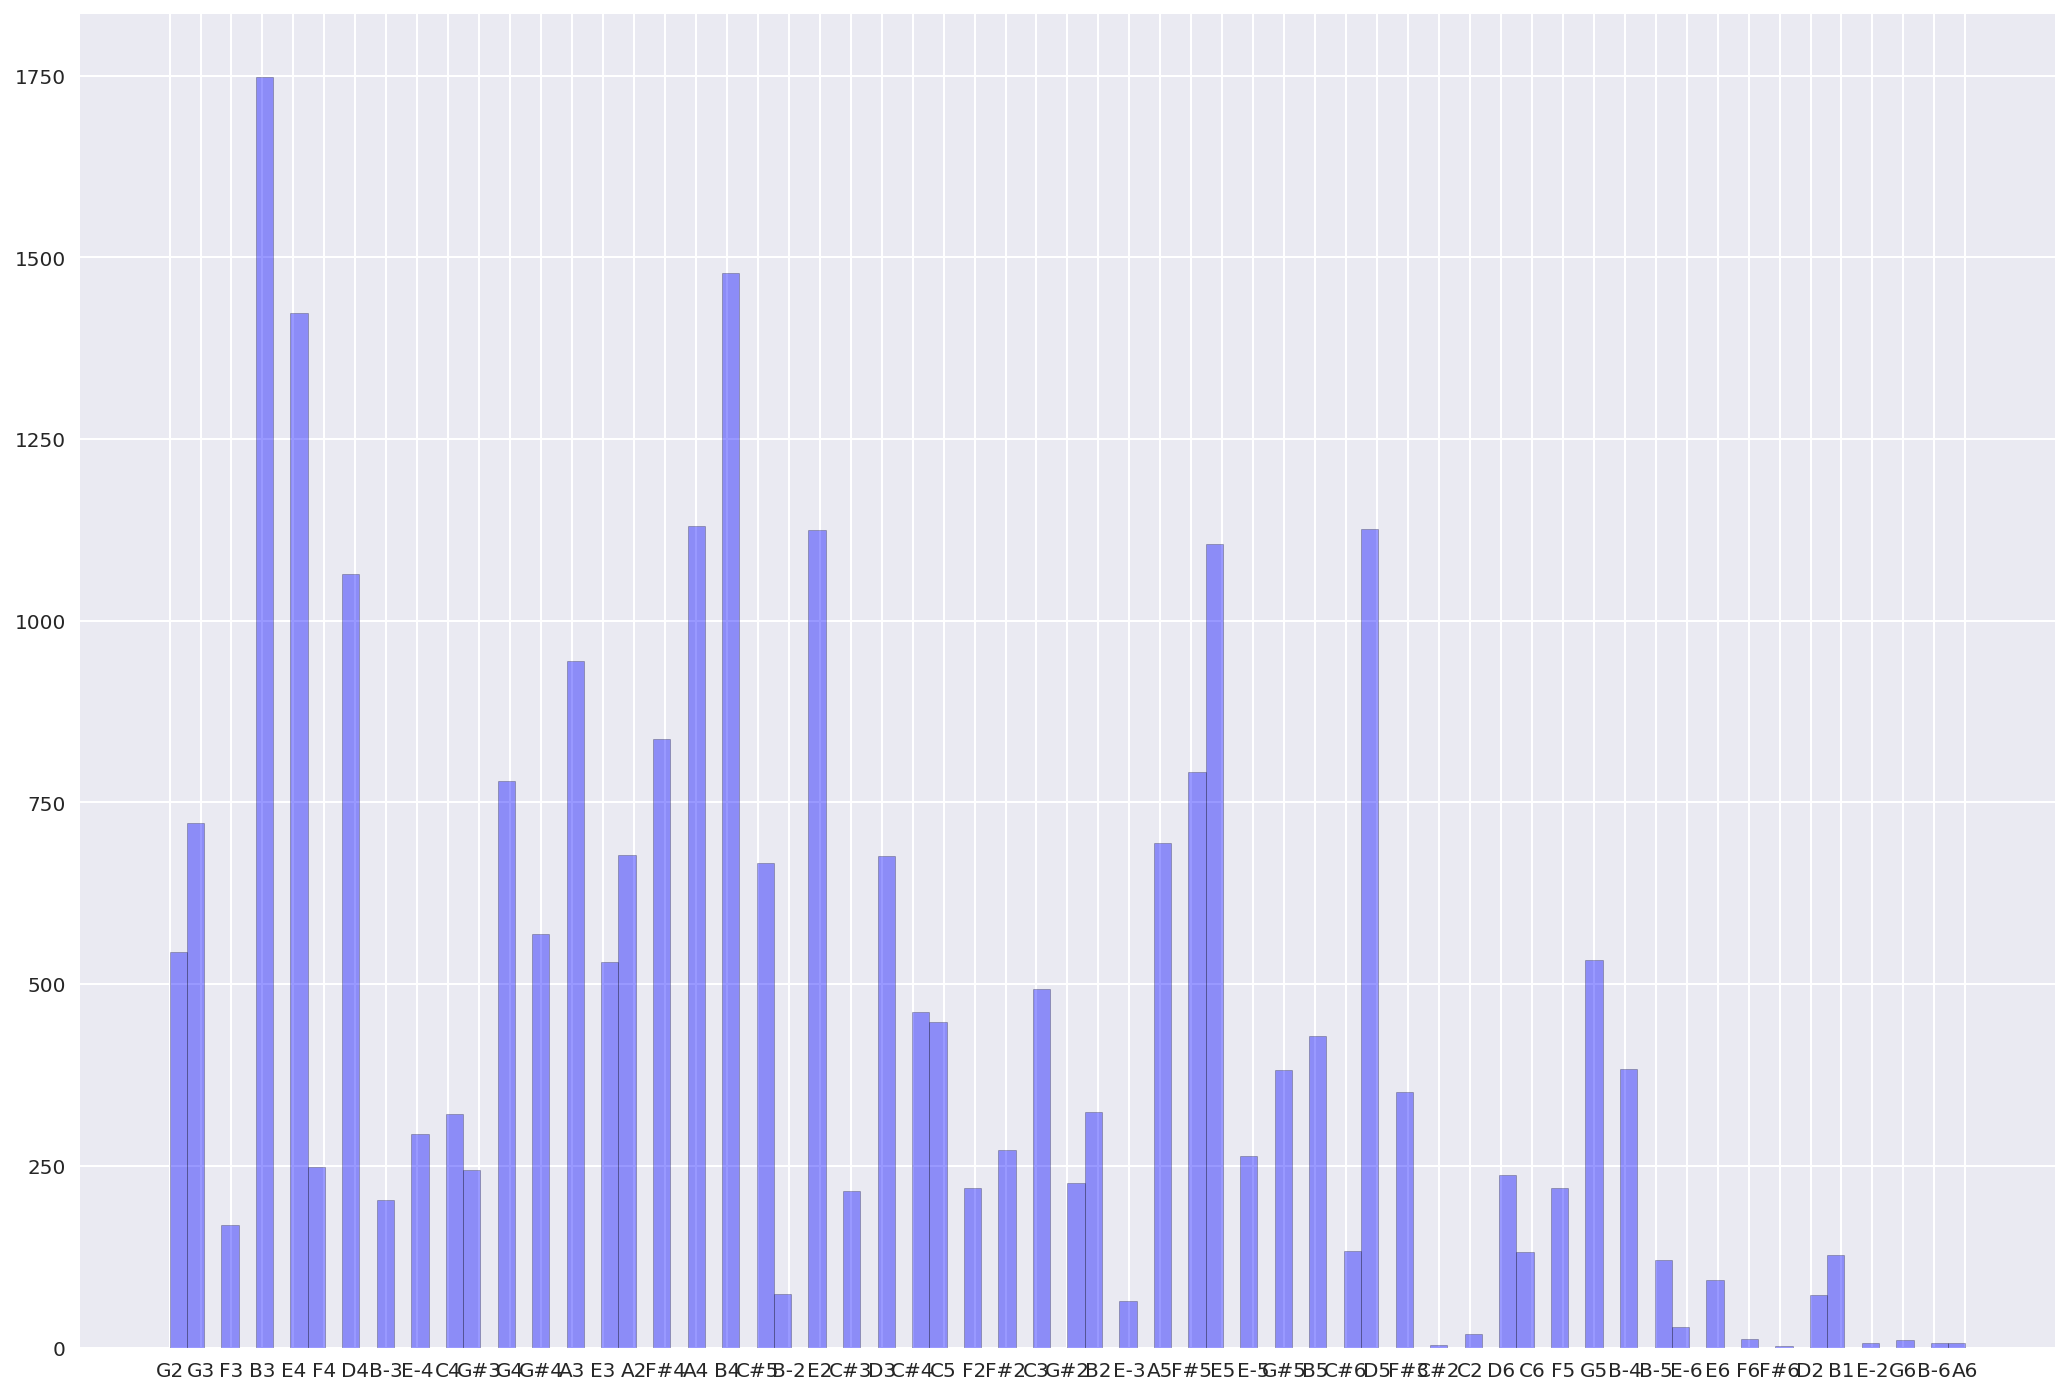

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(17.7,12.27)})
sns.distplot(notes, hist=True, kde=False, 
             bins=104, color = 'blue',hist_kws={'edgecolor':'black'})


In [ ]:
from music21 import converter, instrument, note, chord, midi
 


#midi_path= "ForTheLoveofGod.mid"
midi_path= "FTLOG.mid"


#Read MIDI

mf = midi.MidiFile()
mf.open(midi_path)
mf.read()
mf.close()
    
#List song parts
midi = midi.translate.midiFileToStream(mf)
partStream = midi.parts.stream()
print("List of instruments found on MIDI file:")
for p in partStream:
    print (p.partName)



In [17]:

notes = []
chords = []
duration = []
notes_to_parse = None
parts = midi.parts.stream()

print("Elements of the MIDI: ",midi.elements)
print("Parts of the MIDI: ",parts)
print("LEN parts:", len(parts))

#extracting the melody part 

if parts: # file has instrument parts
    notes_to_parse = parts.parts[0].recurse()
else: # file has notes flat structure
    notes_to_parse = midi.flat.notes

#parse notes,duration an chords

for element in notes_to_parse:
    if isinstance(element, note.Note):
        notes.append(str(element.pitch))
        duration.append(str(element.duration.quarterLength))
    elif isinstance(element, chord.Chord):
        chords.append('.'.join(str(n) for n in element.normalOrder))

print("DURATION:", duration)
print("CHORD: ",chords)
print("Total ",len(notes)," NOTES. List: ", notes)
    

AttributeError: module 'music21.midi' has no attribute 'parts'

# NOTES: Create the training sequences and training the model for predicting notes, taking in account the 10 notes played before

In [4]:
#convert notes to numbers via dictionary


allnotes = sorted(set(item for item in notes))
print ("All notes in the song:")
print(allnotes)

#make a dict

notedict = dict((note, number) for number, note in enumerate(allnotes))
print ("Dictionary Created:")
print(notedict)
vocab = len(notedict)

#prepare sequences for training.

sequence_length = 7
ninput = []
noutput = [] 

for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    ninput.append([notedict[char] for char in sequence_in])
    noutput.append(notedict[sequence_out])
    
patterns = len(ninput)
print("")
print("Number of sequences: ",patterns)
print("")
print("Example of sequence created:")
print(ninput[116],"->--next note: --> ",noutput[116])
print(ninput[17],"->--next note: --> ",noutput[17])
print(ninput[7185],"->--next note: --> ",noutput[7185])
print(ninput[3119],"->--next note: --> ",noutput[3119])

# We need a copy not normalized of the input sequences for the prediction later on

ninputclean = ninput


All notes in the song:
['A2', 'A3', 'A4', 'A5', 'A6', 'B-2', 'B-3', 'B-4', 'B-5', 'B-6', 'B1', 'B2', 'B3', 'B4', 'B5', 'C#2', 'C#3', 'C#4', 'C#5', 'C#6', 'C2', 'C3', 'C4', 'C5', 'C6', 'D2', 'D3', 'D4', 'D5', 'D6', 'E-2', 'E-3', 'E-4', 'E-5', 'E-6', 'E2', 'E3', 'E4', 'E5', 'E6', 'F#2', 'F#3', 'F#4', 'F#5', 'F#6', 'F2', 'F3', 'F4', 'F5', 'F6', 'G#2', 'G#3', 'G#4', 'G#5', 'G2', 'G3', 'G4', 'G5', 'G6']
Dictionary Created:
{'A2': 0, 'A3': 1, 'A4': 2, 'A5': 3, 'A6': 4, 'B-2': 5, 'B-3': 6, 'B-4': 7, 'B-5': 8, 'B-6': 9, 'B1': 10, 'B2': 11, 'B3': 12, 'B4': 13, 'B5': 14, 'C#2': 15, 'C#3': 16, 'C#4': 17, 'C#5': 18, 'C#6': 19, 'C2': 20, 'C3': 21, 'C4': 22, 'C5': 23, 'C6': 24, 'D2': 25, 'D3': 26, 'D4': 27, 'D5': 28, 'D6': 29, 'E-2': 30, 'E-3': 31, 'E-4': 32, 'E-5': 33, 'E-6': 34, 'E2': 35, 'E3': 36, 'E4': 37, 'E5': 38, 'E6': 39, 'F#2': 40, 'F#3': 41, 'F#4': 42, 'F#5': 43, 'F#6': 44, 'F2': 45, 'F3': 46, 'F4': 47, 'F5': 48, 'F6': 49, 'G#2': 50, 'G#3': 51, 'G#4': 52, 'G#5': 53, 'G2': 54, 'G3': 55, 'G4

In [5]:
import numpy
from keras.utils import np_utils

# Convert it to numPy

ninput = numpy.reshape(ninput, (patterns, sequence_length, 1))

# normalize input
ninput = ninput / float(vocab)

#Preparare Output for Neural Network, sparse vector format.
print('example output before categorical')
print(noutput[13])
noutput = np_utils.to_categorical(noutput)
print('example output after categorical')

print(noutput[13])

Using TensorFlow backend.


example output before categorical
12
example output after categorical
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [7]:
# create the model itself

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout, TimeDistributed
from keras.optimizers import Adam, RMSprop

print("Shape of input matrix:")
print(ninput.shape[1], ninput.shape[2])
print("Shape of Output:")
print(vocab)
model = Sequential()
model.add(LSTM(
        256,
        input_shape=(ninput.shape[1], ninput.shape[2]),
        return_sequences=True, 
    ))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256,return_sequences=False))
#model.add(Dense(256))
model.add(Dropout(0.2))
model.add(Dense(vocab))
model.add(Activation('softmax'))

rms = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

#model.add(TimeDistributed(Dense(vocab, activation='sigmoid')))
model.compile(loss='categorical_crossentropy', optimizer=rms,  metrics=['accuracy'])
model.summary()

Shape of input matrix:
7 1
Shape of Output:
59
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 7, 256)            264192    
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 256)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 7, 256)            525312    
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 256)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 7, 128)            197120    
_________________________________________________________________
dropout_8 (Dropout)          (None, 7, 128)            0         
_________________________________________________________________
lstm_9 (LSTM)                

Train on 25156 samples, validate on 1324 samples
Epoch 1/1000
25156/25156 [==============================] - 18s 730us/step - loss: 0.9504 - acc: 0.7125 - val_loss: 0.6336 - val_acc: 0.8331
Epoch 2/1000
25156/25156 [==============================] - 19s 757us/step - loss: 0.9316 - acc: 0.7184 - val_loss: 0.5545 - val_acc: 0.8520
Epoch 3/1000
25156/25156 [==============================] - 19s 765us/step - loss: 0.9290 - acc: 0.7135 - val_loss: 0.4882 - val_acc: 0.8792
Epoch 4/1000
25156/25156 [==============================] - 18s 734us/step - loss: 0.9158 - acc: 0.7215 - val_loss: 0.4444 - val_acc: 0.8852
Epoch 5/1000
25156/25156 [==============================] - 19s 758us/step - loss: 0.9094 - acc: 0.7239 - val_loss: 0.5728 - val_acc: 0.8520
Epoch 6/1000
25156/25156 [==============================] - 19s 744us/step - loss: 0.9250 - acc: 0.7162 - val_loss: 0.4356 - val_acc: 0.8890
Epoch 7/1000
25156/25156 [==============================] - 19s 742us/step - loss: 0.9044 - acc: 0.7265 -

25156/25156 [==============================] - 18s 727us/step - loss: 0.6799 - acc: 0.7903 - val_loss: 0.5120 - val_acc: 0.8618
Epoch 59/1000
25156/25156 [==============================] - 18s 735us/step - loss: 0.6743 - acc: 0.7916 - val_loss: 0.2896 - val_acc: 0.9184
Epoch 60/1000
25156/25156 [==============================] - 19s 757us/step - loss: 0.6709 - acc: 0.7909 - val_loss: 0.3877 - val_acc: 0.8754
Epoch 61/1000
25156/25156 [==============================] - 19s 767us/step - loss: 0.6779 - acc: 0.7919 - val_loss: 0.2710 - val_acc: 0.9290
Epoch 62/1000
25156/25156 [==============================] - 18s 731us/step - loss: 0.6590 - acc: 0.7966 - val_loss: 0.3358 - val_acc: 0.9048
Epoch 63/1000
25156/25156 [==============================] - 18s 730us/step - loss: 0.6739 - acc: 0.7914 - val_loss: 0.2624 - val_acc: 0.9275
Epoch 64/1000
25156/25156 [==============================] - 19s 745us/step - loss: 0.6583 - acc: 0.7958 - val_loss: 0.3417 - val_acc: 0.9026
Epoch 65/1000
25156/

25156/25156 [==============================] - 18s 732us/step - loss: 0.5480 - acc: 0.8291 - val_loss: 0.2900 - val_acc: 0.9147
Epoch 116/1000
25156/25156 [==============================] - 19s 744us/step - loss: 0.5386 - acc: 0.8322 - val_loss: 0.2437 - val_acc: 0.9252
Epoch 117/1000
25156/25156 [==============================] - 19s 743us/step - loss: 0.5548 - acc: 0.8260 - val_loss: 0.2820 - val_acc: 0.9071
Epoch 118/1000
25156/25156 [==============================] - 19s 742us/step - loss: 0.5268 - acc: 0.8346 - val_loss: 0.2314 - val_acc: 0.9282
Epoch 119/1000
25156/25156 [==============================] - 19s 763us/step - loss: 0.5520 - acc: 0.8283 - val_loss: 0.3442 - val_acc: 0.9041
Epoch 120/1000
25156/25156 [==============================] - 18s 733us/step - loss: 0.5317 - acc: 0.8325 - val_loss: 0.2122 - val_acc: 0.9298
Epoch 121/1000
25156/25156 [==============================] - 18s 735us/step - loss: 0.5214 - acc: 0.8383 - val_loss: 0.3796 - val_acc: 0.8799
Epoch 122/1000

25156/25156 [==============================] - 19s 743us/step - loss: 0.4614 - acc: 0.8541 - val_loss: 0.1922 - val_acc: 0.9396
Epoch 173/1000
25156/25156 [==============================] - 18s 730us/step - loss: 0.4783 - acc: 0.8520 - val_loss: 0.2049 - val_acc: 0.9366
Epoch 174/1000
25156/25156 [==============================] - 18s 727us/step - loss: 0.4716 - acc: 0.8550 - val_loss: 0.2109 - val_acc: 0.9267
Epoch 175/1000
25156/25156 [==============================] - 18s 734us/step - loss: 0.4715 - acc: 0.8533 - val_loss: 0.1869 - val_acc: 0.9373
Epoch 176/1000
25156/25156 [==============================] - 18s 725us/step - loss: 0.4721 - acc: 0.8533 - val_loss: 0.2624 - val_acc: 0.9131
Epoch 177/1000
25156/25156 [==============================] - 20s 780us/step - loss: 0.4605 - acc: 0.8569 - val_loss: 0.2215 - val_acc: 0.9335
Epoch 178/1000
25156/25156 [==============================] - 18s 728us/step - loss: 0.4631 - acc: 0.8544 - val_loss: 0.2201 - val_acc: 0.9328
Epoch 179/1000

25156/25156 [==============================] - 18s 731us/step - loss: 0.4165 - acc: 0.8691 - val_loss: 0.1889 - val_acc: 0.9464
Epoch 230/1000
25156/25156 [==============================] - 19s 744us/step - loss: 0.4306 - acc: 0.8649 - val_loss: 0.2108 - val_acc: 0.9403
Epoch 231/1000
25156/25156 [==============================] - 18s 726us/step - loss: 0.4106 - acc: 0.8707 - val_loss: 0.1974 - val_acc: 0.9335
Epoch 232/1000
25156/25156 [==============================] - 18s 734us/step - loss: 0.4068 - acc: 0.8730 - val_loss: 0.2195 - val_acc: 0.9252
Epoch 233/1000
25156/25156 [==============================] - 18s 726us/step - loss: 0.4173 - acc: 0.8693 - val_loss: 0.2430 - val_acc: 0.9207
Epoch 234/1000
25156/25156 [==============================] - 18s 730us/step - loss: 0.4115 - acc: 0.8699 - val_loss: 0.1948 - val_acc: 0.9411
Epoch 235/1000
25156/25156 [==============================] - 20s 776us/step - loss: 0.4203 - acc: 0.8670 - val_loss: 0.2151 - val_acc: 0.9290
Epoch 236/1000

25156/25156 [==============================] - 18s 731us/step - loss: 0.3872 - acc: 0.8770 - val_loss: 0.1841 - val_acc: 0.9366
Epoch 287/1000
25156/25156 [==============================] - 18s 730us/step - loss: 0.3826 - acc: 0.8798 - val_loss: 0.1845 - val_acc: 0.9366
Epoch 288/1000
25156/25156 [==============================] - 18s 728us/step - loss: 0.3840 - acc: 0.8804 - val_loss: 0.1860 - val_acc: 0.9396
Epoch 289/1000
25156/25156 [==============================] - 18s 732us/step - loss: 0.3754 - acc: 0.8802 - val_loss: 0.2362 - val_acc: 0.9245
Epoch 290/1000
25156/25156 [==============================] - 18s 729us/step - loss: 0.3883 - acc: 0.8789 - val_loss: 0.1932 - val_acc: 0.9366
Epoch 291/1000
25156/25156 [==============================] - 18s 731us/step - loss: 0.3769 - acc: 0.8805 - val_loss: 0.2014 - val_acc: 0.9313
Epoch 292/1000
25156/25156 [==============================] - 18s 731us/step - loss: 0.3828 - acc: 0.8811 - val_loss: 0.1841 - val_acc: 0.9366
Epoch 293/1000

25156/25156 [==============================] - 18s 732us/step - loss: 0.3534 - acc: 0.8898 - val_loss: 0.1956 - val_acc: 0.9320
Epoch 344/1000
25156/25156 [==============================] - 18s 730us/step - loss: 0.3529 - acc: 0.8882 - val_loss: 0.2103 - val_acc: 0.9252
Epoch 345/1000
25156/25156 [==============================] - 18s 735us/step - loss: 0.3495 - acc: 0.8908 - val_loss: 0.1747 - val_acc: 0.9403
Epoch 346/1000
25156/25156 [==============================] - 19s 755us/step - loss: 0.3602 - acc: 0.8867 - val_loss: 0.1696 - val_acc: 0.9456
Epoch 347/1000
25156/25156 [==============================] - 18s 729us/step - loss: 0.3596 - acc: 0.8873 - val_loss: 0.1582 - val_acc: 0.9517
Epoch 348/1000
25156/25156 [==============================] - 18s 728us/step - loss: 0.3569 - acc: 0.8877 - val_loss: 0.1835 - val_acc: 0.9373
Epoch 349/1000
25156/25156 [==============================] - 19s 745us/step - loss: 0.3390 - acc: 0.8918 - val_loss: 0.2146 - val_acc: 0.9237
Epoch 350/1000

25156/25156 [==============================] - 19s 746us/step - loss: 0.3228 - acc: 0.8986 - val_loss: 0.1721 - val_acc: 0.9396
Epoch 401/1000
25156/25156 [==============================] - 18s 726us/step - loss: 0.3251 - acc: 0.8980 - val_loss: 0.2600 - val_acc: 0.9169
Epoch 402/1000
25156/25156 [==============================] - 19s 745us/step - loss: 0.3270 - acc: 0.8975 - val_loss: 0.2858 - val_acc: 0.9139
Epoch 403/1000
25156/25156 [==============================] - 19s 744us/step - loss: 0.3401 - acc: 0.8930 - val_loss: 0.1756 - val_acc: 0.9403
Epoch 404/1000
25156/25156 [==============================] - 18s 730us/step - loss: 0.3319 - acc: 0.8954 - val_loss: 0.1556 - val_acc: 0.9464
Epoch 405/1000
25156/25156 [==============================] - 18s 731us/step - loss: 0.3268 - acc: 0.8978 - val_loss: 0.2471 - val_acc: 0.9245
Epoch 406/1000
25156/25156 [==============================] - 18s 729us/step - loss: 0.3389 - acc: 0.8932 - val_loss: 0.1953 - val_acc: 0.9366
Epoch 407/1000

25156/25156 [==============================] - 19s 767us/step - loss: 0.3192 - acc: 0.8991 - val_loss: 0.1588 - val_acc: 0.9502
Epoch 458/1000
25156/25156 [==============================] - 19s 745us/step - loss: 0.3123 - acc: 0.9018 - val_loss: 0.1600 - val_acc: 0.9502
Epoch 459/1000
25156/25156 [==============================] - 18s 735us/step - loss: 0.3083 - acc: 0.9026 - val_loss: 0.2416 - val_acc: 0.9147
Epoch 460/1000
25156/25156 [==============================] - 19s 756us/step - loss: 0.3176 - acc: 0.9004 - val_loss: 0.2005 - val_acc: 0.9358
Epoch 461/1000
25156/25156 [==============================] - 19s 756us/step - loss: 0.3158 - acc: 0.8991 - val_loss: 0.2267 - val_acc: 0.9305
Epoch 462/1000
25156/25156 [==============================] - 18s 731us/step - loss: 0.3132 - acc: 0.9014 - val_loss: 0.1534 - val_acc: 0.9502
Epoch 463/1000
25156/25156 [==============================] - 18s 733us/step - loss: 0.3157 - acc: 0.9007 - val_loss: 0.1598 - val_acc: 0.9479
Epoch 464/1000

25156/25156 [==============================] - 18s 727us/step - loss: 0.2998 - acc: 0.9048 - val_loss: 0.1496 - val_acc: 0.9494
Epoch 515/1000
25156/25156 [==============================] - 19s 763us/step - loss: 0.2946 - acc: 0.9083 - val_loss: 0.1795 - val_acc: 0.9449
Epoch 516/1000
25156/25156 [==============================] - 18s 729us/step - loss: 0.3061 - acc: 0.9047 - val_loss: 0.1845 - val_acc: 0.9434
Epoch 517/1000
25156/25156 [==============================] - 19s 746us/step - loss: 0.2967 - acc: 0.9053 - val_loss: 0.1820 - val_acc: 0.9396
Epoch 518/1000
25156/25156 [==============================] - 18s 727us/step - loss: 0.3023 - acc: 0.9046 - val_loss: 0.1759 - val_acc: 0.9426
Epoch 519/1000
25156/25156 [==============================] - 19s 747us/step - loss: 0.3049 - acc: 0.9049 - val_loss: 0.1927 - val_acc: 0.9350
Epoch 520/1000
25156/25156 [==============================] - 18s 728us/step - loss: 0.2893 - acc: 0.9086 - val_loss: 0.1640 - val_acc: 0.9517
Epoch 521/1000

25156/25156 [==============================] - 19s 744us/step - loss: 0.2855 - acc: 0.9098 - val_loss: 0.1588 - val_acc: 0.9509
Epoch 572/1000
25156/25156 [==============================] - 18s 734us/step - loss: 0.2801 - acc: 0.9123 - val_loss: 0.1546 - val_acc: 0.9517
Epoch 573/1000
25156/25156 [==============================] - 19s 767us/step - loss: 0.2929 - acc: 0.9074 - val_loss: 0.1484 - val_acc: 0.9486
Epoch 574/1000
25156/25156 [==============================] - 18s 730us/step - loss: 0.2736 - acc: 0.9137 - val_loss: 0.1634 - val_acc: 0.9471
Epoch 575/1000
25156/25156 [==============================] - 19s 743us/step - loss: 0.2868 - acc: 0.9080 - val_loss: 0.1567 - val_acc: 0.9502
Epoch 576/1000
25156/25156 [==============================] - 18s 730us/step - loss: 0.2922 - acc: 0.9073 - val_loss: 0.1581 - val_acc: 0.9509
Epoch 577/1000
25156/25156 [==============================] - 18s 727us/step - loss: 0.2726 - acc: 0.9151 - val_loss: 0.1561 - val_acc: 0.9517
Epoch 578/1000

25156/25156 [==============================] - 19s 744us/step - loss: 0.2764 - acc: 0.9128 - val_loss: 0.1526 - val_acc: 0.9494
Epoch 629/1000
25156/25156 [==============================] - 18s 731us/step - loss: 0.2719 - acc: 0.9139 - val_loss: 0.1494 - val_acc: 0.9509
Epoch 630/1000
25156/25156 [==============================] - 19s 736us/step - loss: 0.2689 - acc: 0.9164 - val_loss: 0.1468 - val_acc: 0.9517
Epoch 631/1000
25156/25156 [==============================] - 20s 777us/step - loss: 0.2725 - acc: 0.9124 - val_loss: 0.1590 - val_acc: 0.9418
Epoch 632/1000
25156/25156 [==============================] - 19s 741us/step - loss: 0.2816 - acc: 0.9134 - val_loss: 0.1381 - val_acc: 0.9524
Epoch 633/1000
25156/25156 [==============================] - 18s 732us/step - loss: 0.2658 - acc: 0.9167 - val_loss: 0.1432 - val_acc: 0.9517
Epoch 634/1000
25156/25156 [==============================] - 18s 730us/step - loss: 0.2756 - acc: 0.9132 - val_loss: 0.1520 - val_acc: 0.9502
Epoch 635/1000

25156/25156 [==============================] - 19s 756us/step - loss: 0.2624 - acc: 0.9170 - val_loss: 0.1799 - val_acc: 0.9441
Epoch 686/1000
25156/25156 [==============================] - 19s 744us/step - loss: 0.2600 - acc: 0.9172 - val_loss: 0.1443 - val_acc: 0.9532
Epoch 687/1000
25156/25156 [==============================] - 18s 733us/step - loss: 0.2629 - acc: 0.9164 - val_loss: 0.2706 - val_acc: 0.9147
Epoch 688/1000
25156/25156 [==============================] - 19s 745us/step - loss: 0.2640 - acc: 0.9167 - val_loss: 0.1591 - val_acc: 0.9479
Epoch 689/1000
25156/25156 [==============================] - 20s 777us/step - loss: 0.2611 - acc: 0.9172 - val_loss: 0.1567 - val_acc: 0.9517
Epoch 690/1000
25156/25156 [==============================] - 19s 758us/step - loss: 0.2623 - acc: 0.9168 - val_loss: 0.1529 - val_acc: 0.9517
Epoch 691/1000
25156/25156 [==============================] - 18s 733us/step - loss: 0.2652 - acc: 0.9154 - val_loss: 0.1412 - val_acc: 0.9562
Epoch 692/1000

25156/25156 [==============================] - 18s 730us/step - loss: 0.2523 - acc: 0.9199 - val_loss: 0.1411 - val_acc: 0.9554
Epoch 743/1000
25156/25156 [==============================] - 18s 728us/step - loss: 0.2528 - acc: 0.9180 - val_loss: 0.1455 - val_acc: 0.9524
Epoch 744/1000
25156/25156 [==============================] - 18s 733us/step - loss: 0.2482 - acc: 0.9200 - val_loss: 0.1901 - val_acc: 0.9418
Epoch 745/1000
25156/25156 [==============================] - 18s 735us/step - loss: 0.2534 - acc: 0.9193 - val_loss: 0.1578 - val_acc: 0.9486
Epoch 746/1000
25156/25156 [==============================] - 19s 744us/step - loss: 0.2569 - acc: 0.9181 - val_loss: 0.1708 - val_acc: 0.9434
Epoch 747/1000
25156/25156 [==============================] - 19s 763us/step - loss: 0.2558 - acc: 0.9181 - val_loss: 0.1859 - val_acc: 0.9328
Epoch 748/1000
25156/25156 [==============================] - 19s 744us/step - loss: 0.2507 - acc: 0.9191 - val_loss: 0.1627 - val_acc: 0.9509
Epoch 749/1000

25156/25156 [==============================] - 18s 730us/step - loss: 0.2409 - acc: 0.9227 - val_loss: 0.1455 - val_acc: 0.9532
Epoch 800/1000
25156/25156 [==============================] - 18s 730us/step - loss: 0.2433 - acc: 0.9227 - val_loss: 0.1600 - val_acc: 0.9517
Epoch 801/1000
25156/25156 [==============================] - 18s 729us/step - loss: 0.2406 - acc: 0.9223 - val_loss: 0.1466 - val_acc: 0.9524
Epoch 802/1000
25156/25156 [==============================] - 18s 729us/step - loss: 0.2414 - acc: 0.9228 - val_loss: 0.1454 - val_acc: 0.9524
Epoch 803/1000
25156/25156 [==============================] - 18s 729us/step - loss: 0.2517 - acc: 0.9184 - val_loss: 0.1520 - val_acc: 0.9479
Epoch 804/1000
25156/25156 [==============================] - 19s 742us/step - loss: 0.2501 - acc: 0.9221 - val_loss: 0.1537 - val_acc: 0.9532
Epoch 805/1000
25156/25156 [==============================] - 19s 773us/step - loss: 0.2491 - acc: 0.9188 - val_loss: 0.1417 - val_acc: 0.9509
Epoch 806/1000

25156/25156 [==============================] - 18s 729us/step - loss: 0.2392 - acc: 0.9242 - val_loss: 0.1385 - val_acc: 0.9554
Epoch 857/1000
25156/25156 [==============================] - 18s 735us/step - loss: 0.2371 - acc: 0.9248 - val_loss: 0.1244 - val_acc: 0.9577
Epoch 858/1000
25156/25156 [==============================] - 18s 735us/step - loss: 0.2368 - acc: 0.9251 - val_loss: 0.1440 - val_acc: 0.9502
Epoch 859/1000
25156/25156 [==============================] - 19s 743us/step - loss: 0.2414 - acc: 0.9216 - val_loss: 0.1592 - val_acc: 0.9486
Epoch 860/1000
25156/25156 [==============================] - 18s 734us/step - loss: 0.2415 - acc: 0.9233 - val_loss: 0.1507 - val_acc: 0.9479
Epoch 861/1000
25156/25156 [==============================] - 19s 742us/step - loss: 0.2335 - acc: 0.9243 - val_loss: 0.1745 - val_acc: 0.9411
Epoch 862/1000
25156/25156 [==============================] - 19s 742us/step - loss: 0.2352 - acc: 0.9249 - val_loss: 0.1626 - val_acc: 0.9418
Epoch 863/1000

25156/25156 [==============================] - 18s 726us/step - loss: 0.2282 - acc: 0.9275 - val_loss: 0.1349 - val_acc: 0.9562
Epoch 914/1000
25156/25156 [==============================] - 19s 745us/step - loss: 0.2309 - acc: 0.9268 - val_loss: 0.1417 - val_acc: 0.9502
Epoch 915/1000
25156/25156 [==============================] - 18s 726us/step - loss: 0.2303 - acc: 0.9252 - val_loss: 0.1679 - val_acc: 0.9486
Epoch 916/1000
25156/25156 [==============================] - 18s 729us/step - loss: 0.2341 - acc: 0.9255 - val_loss: 0.1606 - val_acc: 0.9441
Epoch 917/1000
25156/25156 [==============================] - 19s 742us/step - loss: 0.2279 - acc: 0.9274 - val_loss: 0.1537 - val_acc: 0.9532
Epoch 918/1000
25156/25156 [==============================] - 18s 727us/step - loss: 0.2355 - acc: 0.9232 - val_loss: 0.1437 - val_acc: 0.9554
Epoch 919/1000
25156/25156 [==============================] - 19s 743us/step - loss: 0.2390 - acc: 0.9232 - val_loss: 0.1984 - val_acc: 0.9366
Epoch 920/1000

25156/25156 [==============================] - 20s 781us/step - loss: 0.2264 - acc: 0.9271 - val_loss: 0.1591 - val_acc: 0.9502
Epoch 971/1000
25156/25156 [==============================] - 19s 744us/step - loss: 0.2240 - acc: 0.9294 - val_loss: 0.1485 - val_acc: 0.9554
Epoch 972/1000
25156/25156 [==============================] - 18s 729us/step - loss: 0.2287 - acc: 0.9288 - val_loss: 0.1300 - val_acc: 0.9600
Epoch 973/1000
25156/25156 [==============================] - 18s 726us/step - loss: 0.2214 - acc: 0.9293 - val_loss: 0.1321 - val_acc: 0.9585
Epoch 974/1000
25156/25156 [==============================] - 18s 735us/step - loss: 0.2183 - acc: 0.9291 - val_loss: 0.1339 - val_acc: 0.9569
Epoch 975/1000
25156/25156 [==============================] - 18s 731us/step - loss: 0.2255 - acc: 0.9257 - val_loss: 0.1478 - val_acc: 0.9592
Epoch 976/1000
25156/25156 [==============================] - 18s 731us/step - loss: 0.2235 - acc: 0.9278 - val_loss: 0.1418 - val_acc: 0.9569
Epoch 977/1000

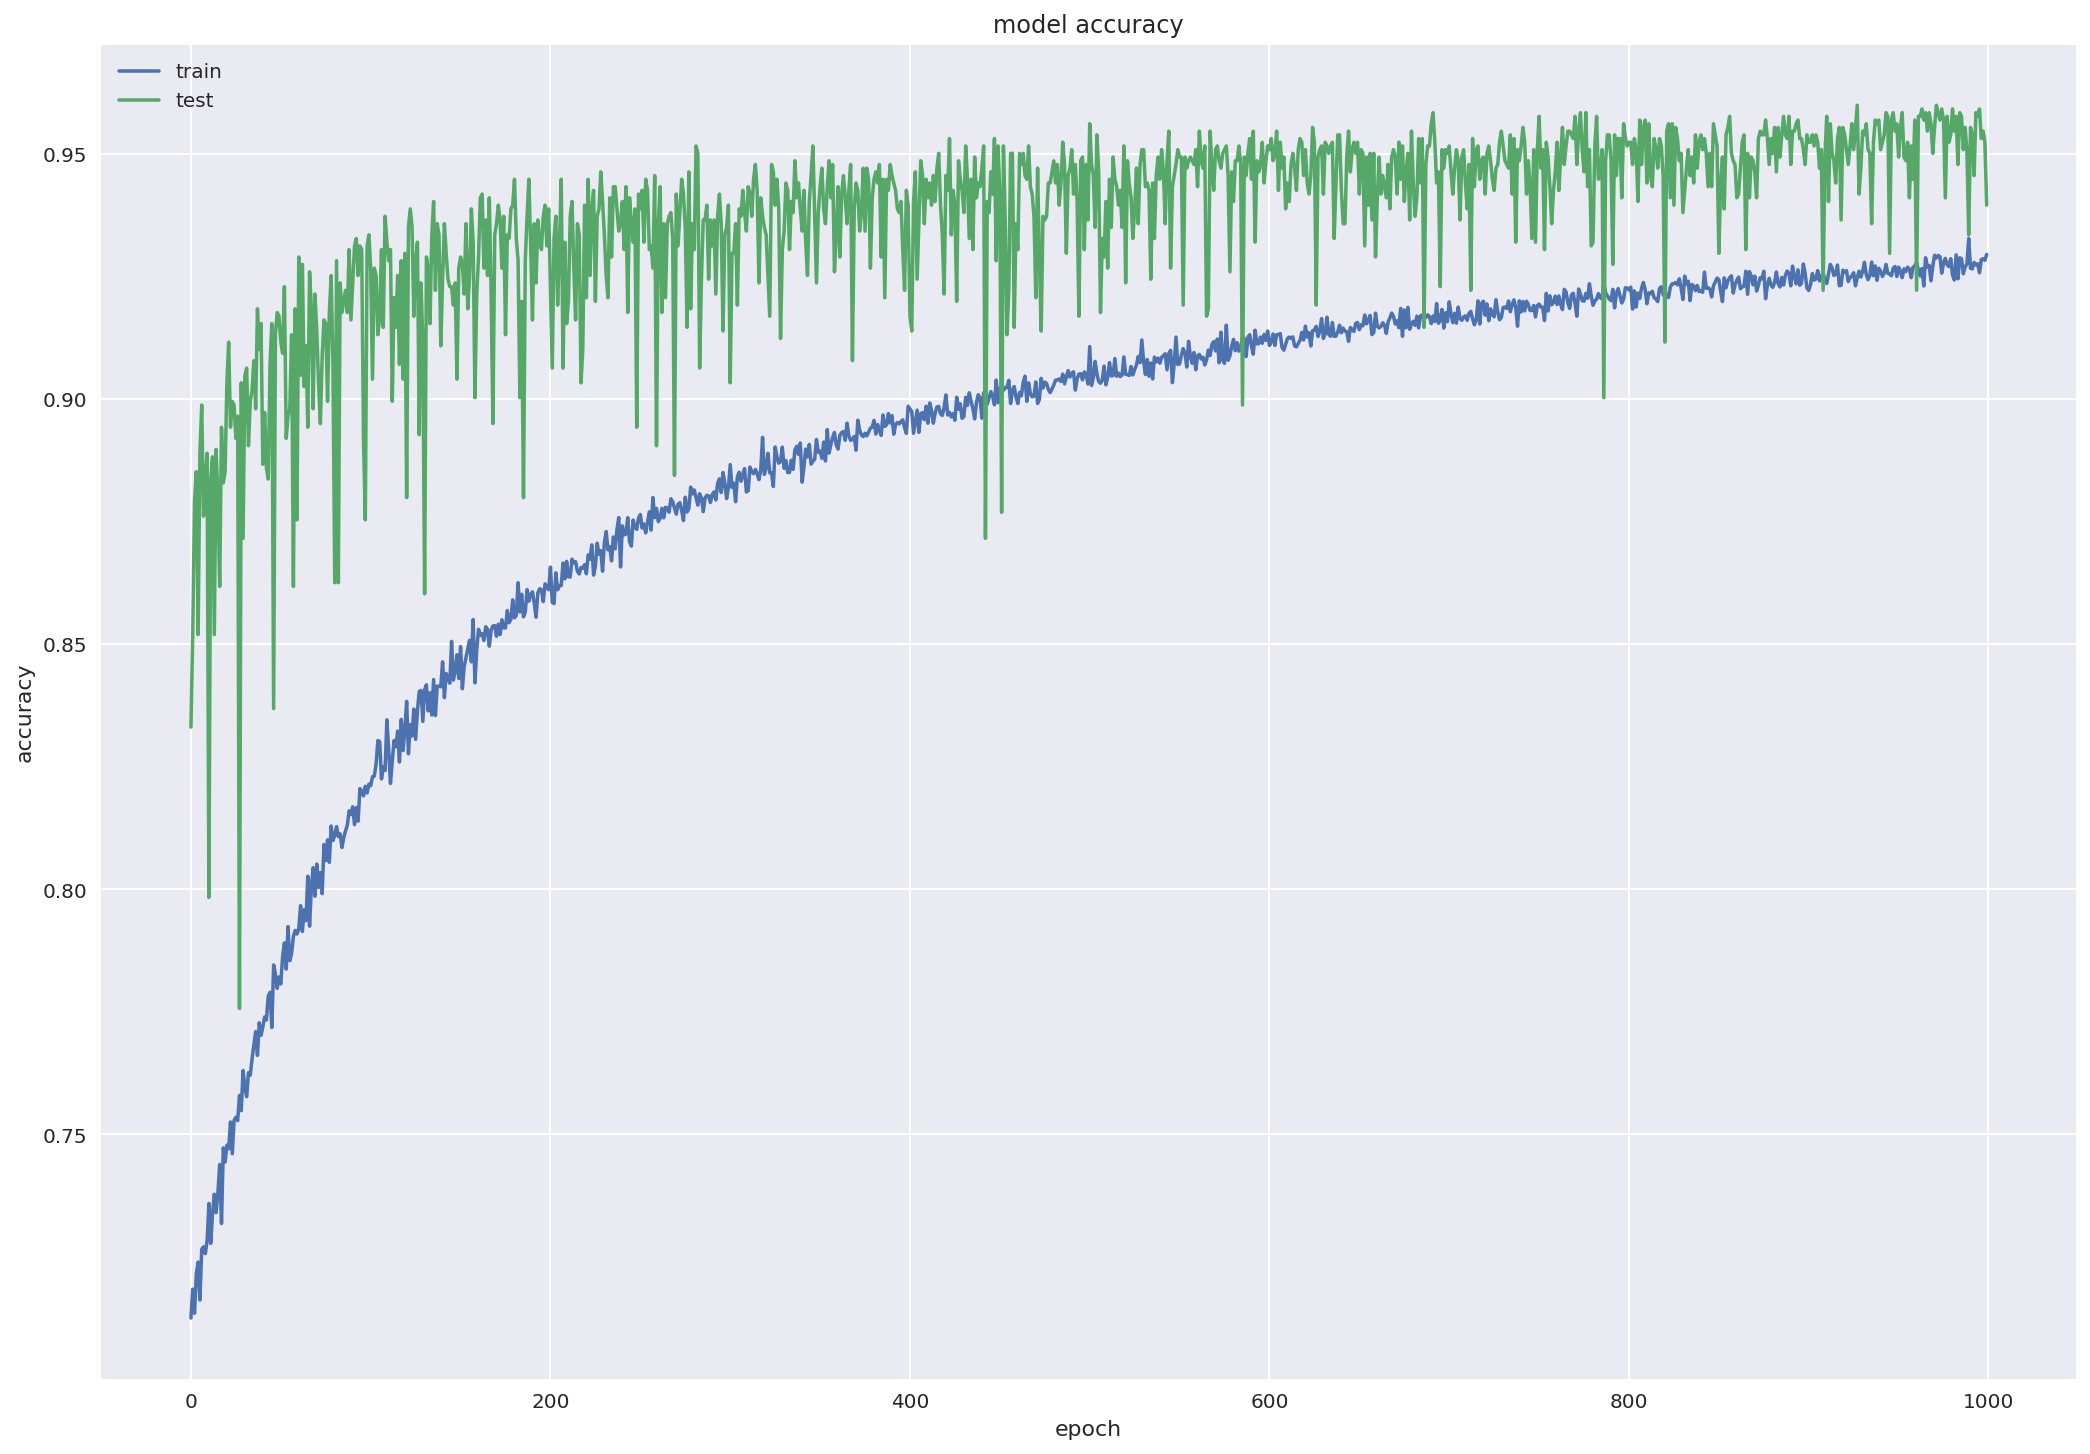

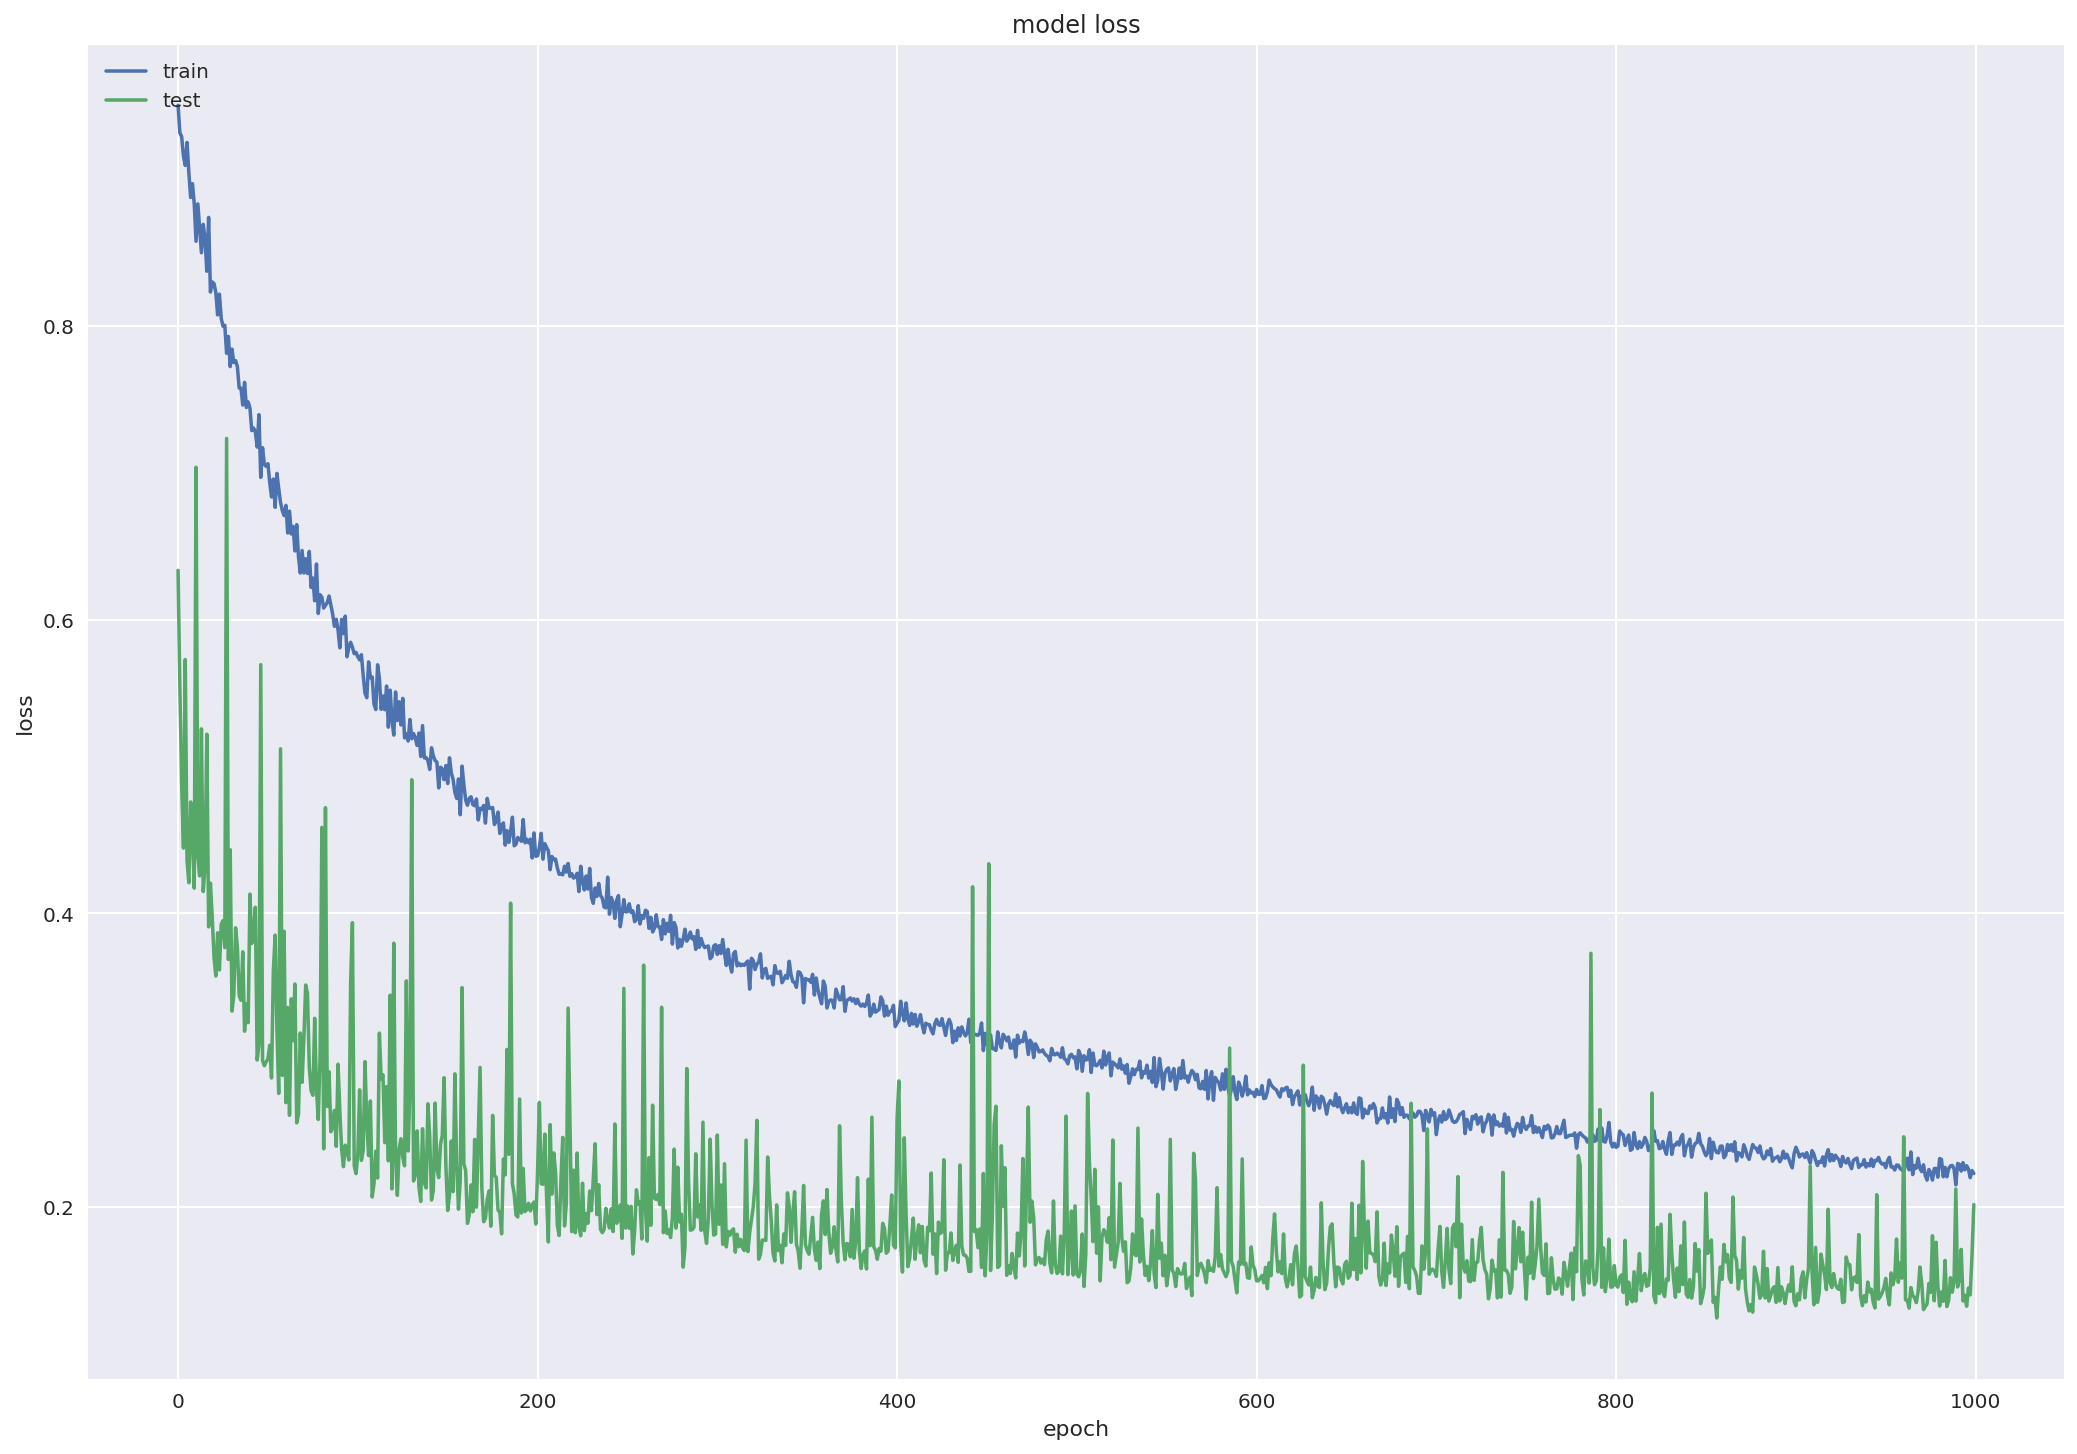

In [9]:
# Train implementing callbacks

import keras

# Implementing callbacks to save model after each epoch, just in case not used by now cholo
savepath = "weights-stage-{epoch:02d}-{loss:.4f}-model.hdf5"    
checkpoint = keras.callbacks.ModelCheckpoint(
    savepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     
history = model.fit(ninput, noutput, epochs=1000, batch_size=512, validation_split=0.05)
scores = model.evaluate(ninput,noutput)

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [10]:
from keras.models import load_model

model.save('automusicNotes_model.h5')  # creates a HDF5 file 'my_model.h5'


---

# DURATION OF NOTES: Now let's create training sequences and train a model to predict duration of the notes

In [106]:
#convert notes to numbers via dictionary


allduration = sorted(set(item for item in duration))
print ("All different durations in the song:")
print(allduration)

#make a dict

durationdict = dict((note, number) for number, note in enumerate(allduration))
print ("Dictionary Created:")
print(durationdict)
vocabd = len(durationdict)

#prepare sequences for training.

sequence_length = 7
ninput = []
noutput = [] 

for i in range(0, len(duration) - sequence_length, 1):
    sequence_in = duration[i:i + sequence_length]
    sequence_out = duration[i + sequence_length]
    ninput.append([durationdict[char] for char in sequence_in])
    noutput.append(durationdict[sequence_out])
patterns = len(ninput)
print("")
print("Number of sequences: ",patterns)
print("")
print("Example of sequence created:")
print(ninput[15],"->--next diuration: --> ",noutput[15])
print(ninput[16],"->--next diuration: --> ",noutput[16])
print(ninput[17],"->--next diuration: --> ",noutput[17])



All different durations in the song:
['0.0', '0.25', '0.5', '0.75', '1.0', '1.25', '1.5', '1.75', '1/3', '10.0', '10.5', '10/3', '11.0', '11/3', '12.0', '12.5', '13.0', '13/3', '14.0', '15.5', '15.75', '16.0', '17/3', '2.0', '2.25', '2.5', '2.75', '2/3', '20.0', '20.5', '23/3', '25/3', '3.0', '3.25', '3.5', '3.75', '31/3', '32.0', '4.0', '4.25', '4.5', '4.75', '4/3', '5.0', '5.25', '5.5', '5.75', '5/3', '6.0', '6.5', '7.0', '7.5', '7.75', '7/3', '8.0', '8/3', '9.5']
Dictionary Created:
{'0.0': 0, '0.25': 1, '0.5': 2, '0.75': 3, '1.0': 4, '1.25': 5, '1.5': 6, '1.75': 7, '1/3': 8, '10.0': 9, '10.5': 10, '10/3': 11, '11.0': 12, '11/3': 13, '12.0': 14, '12.5': 15, '13.0': 16, '13/3': 17, '14.0': 18, '15.5': 19, '15.75': 20, '16.0': 21, '17/3': 22, '2.0': 23, '2.25': 24, '2.5': 25, '2.75': 26, '2/3': 27, '20.0': 28, '20.5': 29, '23/3': 30, '25/3': 31, '3.0': 32, '3.25': 33, '3.5': 34, '3.75': 35, '31/3': 36, '32.0': 37, '4.0': 38, '4.25': 39, '4.5': 40, '4.75': 41, '4/3': 42, '5.0': 43, '5.

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


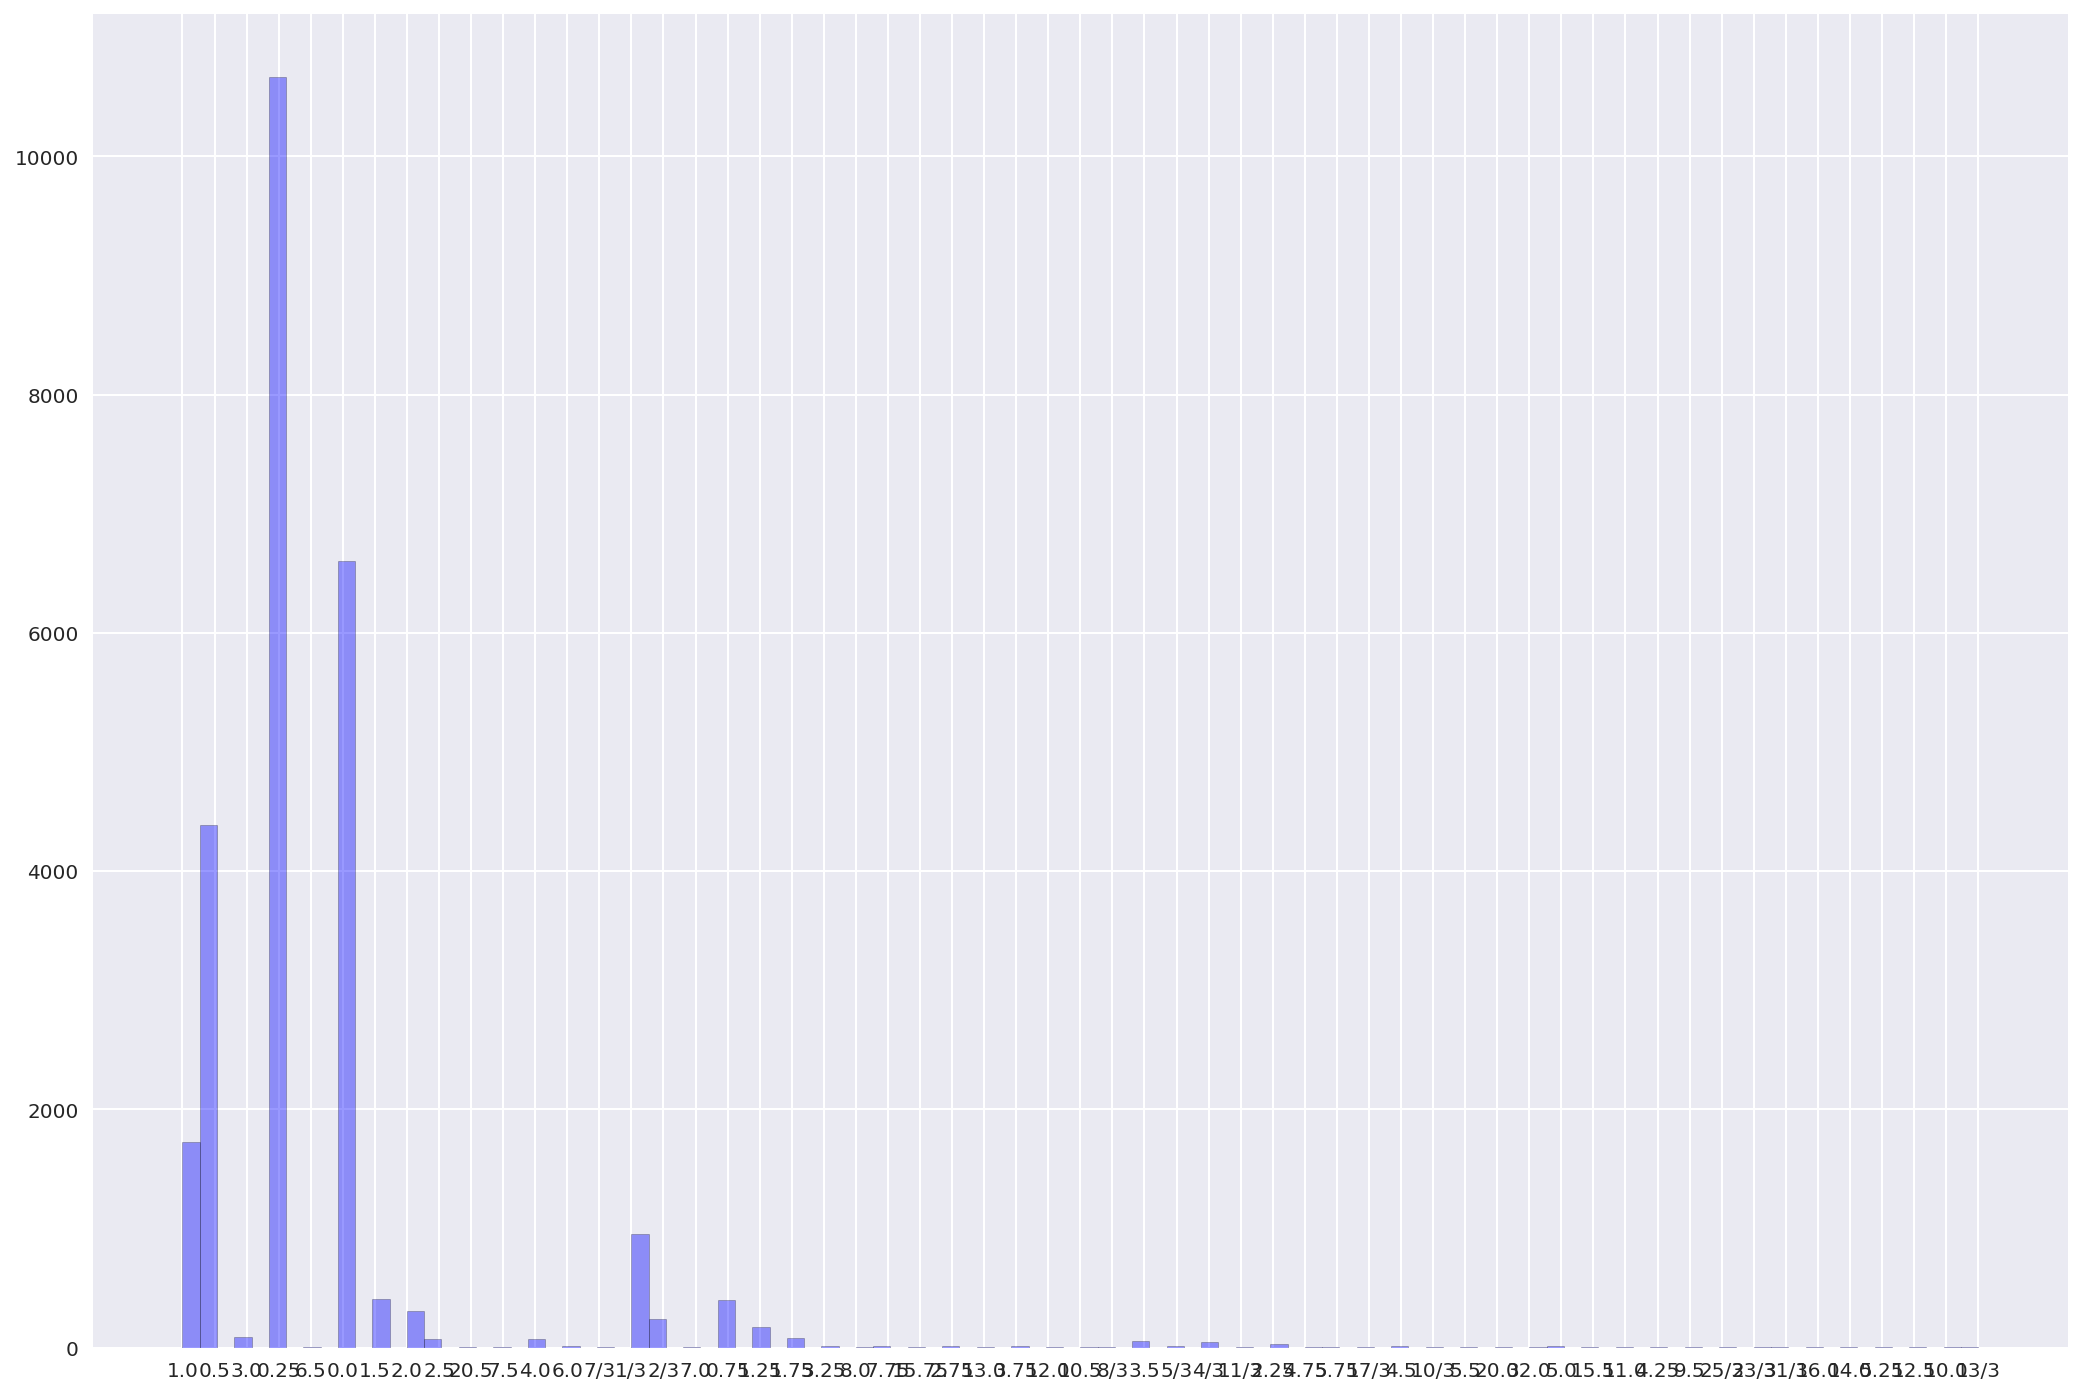

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(17.7,12.27)})
sns.distplot(duration, hist=True, kde=False, 
             bins=104, color = 'blue',hist_kws={'edgecolor':'black'})


In [71]:
import numpy
from keras.utils import np_utils

# Convert it to numPy

ninput = numpy.reshape(ninput, (patterns, sequence_length, 1))

# normalize input
ninput = ninput / float(vocabd)

#Preparare Output for Neural Network, sparse vector format.

print('example output before categorical')
print(noutput[15])
noutput = np_utils.to_categorical(noutput)
print('example output after categorical')

print(noutput[15])


example output before categorical
4
example output after categorical
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [72]:

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout, TimeDistributed
from keras.optimizers import Adam, RMSprop

print("Shape of input matrix:")
print(ninput.shape[1], ninput.shape[2])
print("Shape of Output:")
print(vocab)
modeld = Sequential()
modeld.add(LSTM(
        256,
        input_shape=(ninput.shape[1], ninput.shape[2]),
        return_sequences=True, 
    ))
modeld.add(Dropout(0.3))
modeld.add(LSTM(256, return_sequences=True))
modeld.add(Dropout(0.3))
modeld.add(LSTM(128, return_sequences=True))
modeld.add(Dropout(0.3))
modeld.add(LSTM(128, return_sequences=True))
modeld.add(Dropout(0.2))
modeld.add(LSTM(256,return_sequences=False))
#model.add(Dense(256))
modeld.add(Dropout(0.2))
modeld.add(Dense(vocab))
modeld.add(Activation('softmax'))

rms = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

#model.add(TimeDistributed(Dense(vocab, activation='sigmoid')))
modeld.compile(loss='categorical_crossentropy', optimizer=rms,  metrics=['accuracy'])
modeld.summary()

Shape of input matrix:
7 1
Shape of Output:
57
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 7, 256)            264192    
_________________________________________________________________
dropout_31 (Dropout)         (None, 7, 256)            0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 7, 256)            525312    
_________________________________________________________________
dropout_32 (Dropout)         (None, 7, 256)            0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 7, 128)            197120    
_________________________________________________________________
dropout_33 (Dropout)         (None, 7, 128)            0         
_________________________________________________________________
lstm_34 (LSTM)               

Train on 25156 samples, validate on 1324 samples
Epoch 1/60
25156/25156 [==============================] - 19s 736us/step - loss: 0.9965 - acc: 0.7120 - val_loss: 1.1881 - val_acc: 0.6518
Epoch 2/60
25156/25156 [==============================] - 19s 736us/step - loss: 0.9941 - acc: 0.7126 - val_loss: 1.1801 - val_acc: 0.6450
Epoch 3/60
25156/25156 [==============================] - 19s 765us/step - loss: 0.9880 - acc: 0.7133 - val_loss: 1.1539 - val_acc: 0.6601
Epoch 4/60
25156/25156 [==============================] - 18s 721us/step - loss: 0.9808 - acc: 0.7164 - val_loss: 1.1352 - val_acc: 0.6435
Epoch 5/60
25156/25156 [==============================] - 18s 715us/step - loss: 0.9727 - acc: 0.7169 - val_loss: 1.0819 - val_acc: 0.6918
Epoch 6/60
25156/25156 [==============================] - 18s 724us/step - loss: 0.9689 - acc: 0.7204 - val_loss: 1.1000 - val_acc: 0.6616
Epoch 7/60
25156/25156 [==============================] - 18s 735us/step - loss: 0.9637 - acc: 0.7198 - val_loss: 1.1

25156/25156 [==============================] - 18s 727us/step - loss: 0.6719 - acc: 0.7987 - val_loss: 0.6451 - val_acc: 0.8104
Epoch 60/60
26480/26480 [==============================] - 32s 1ms/step
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


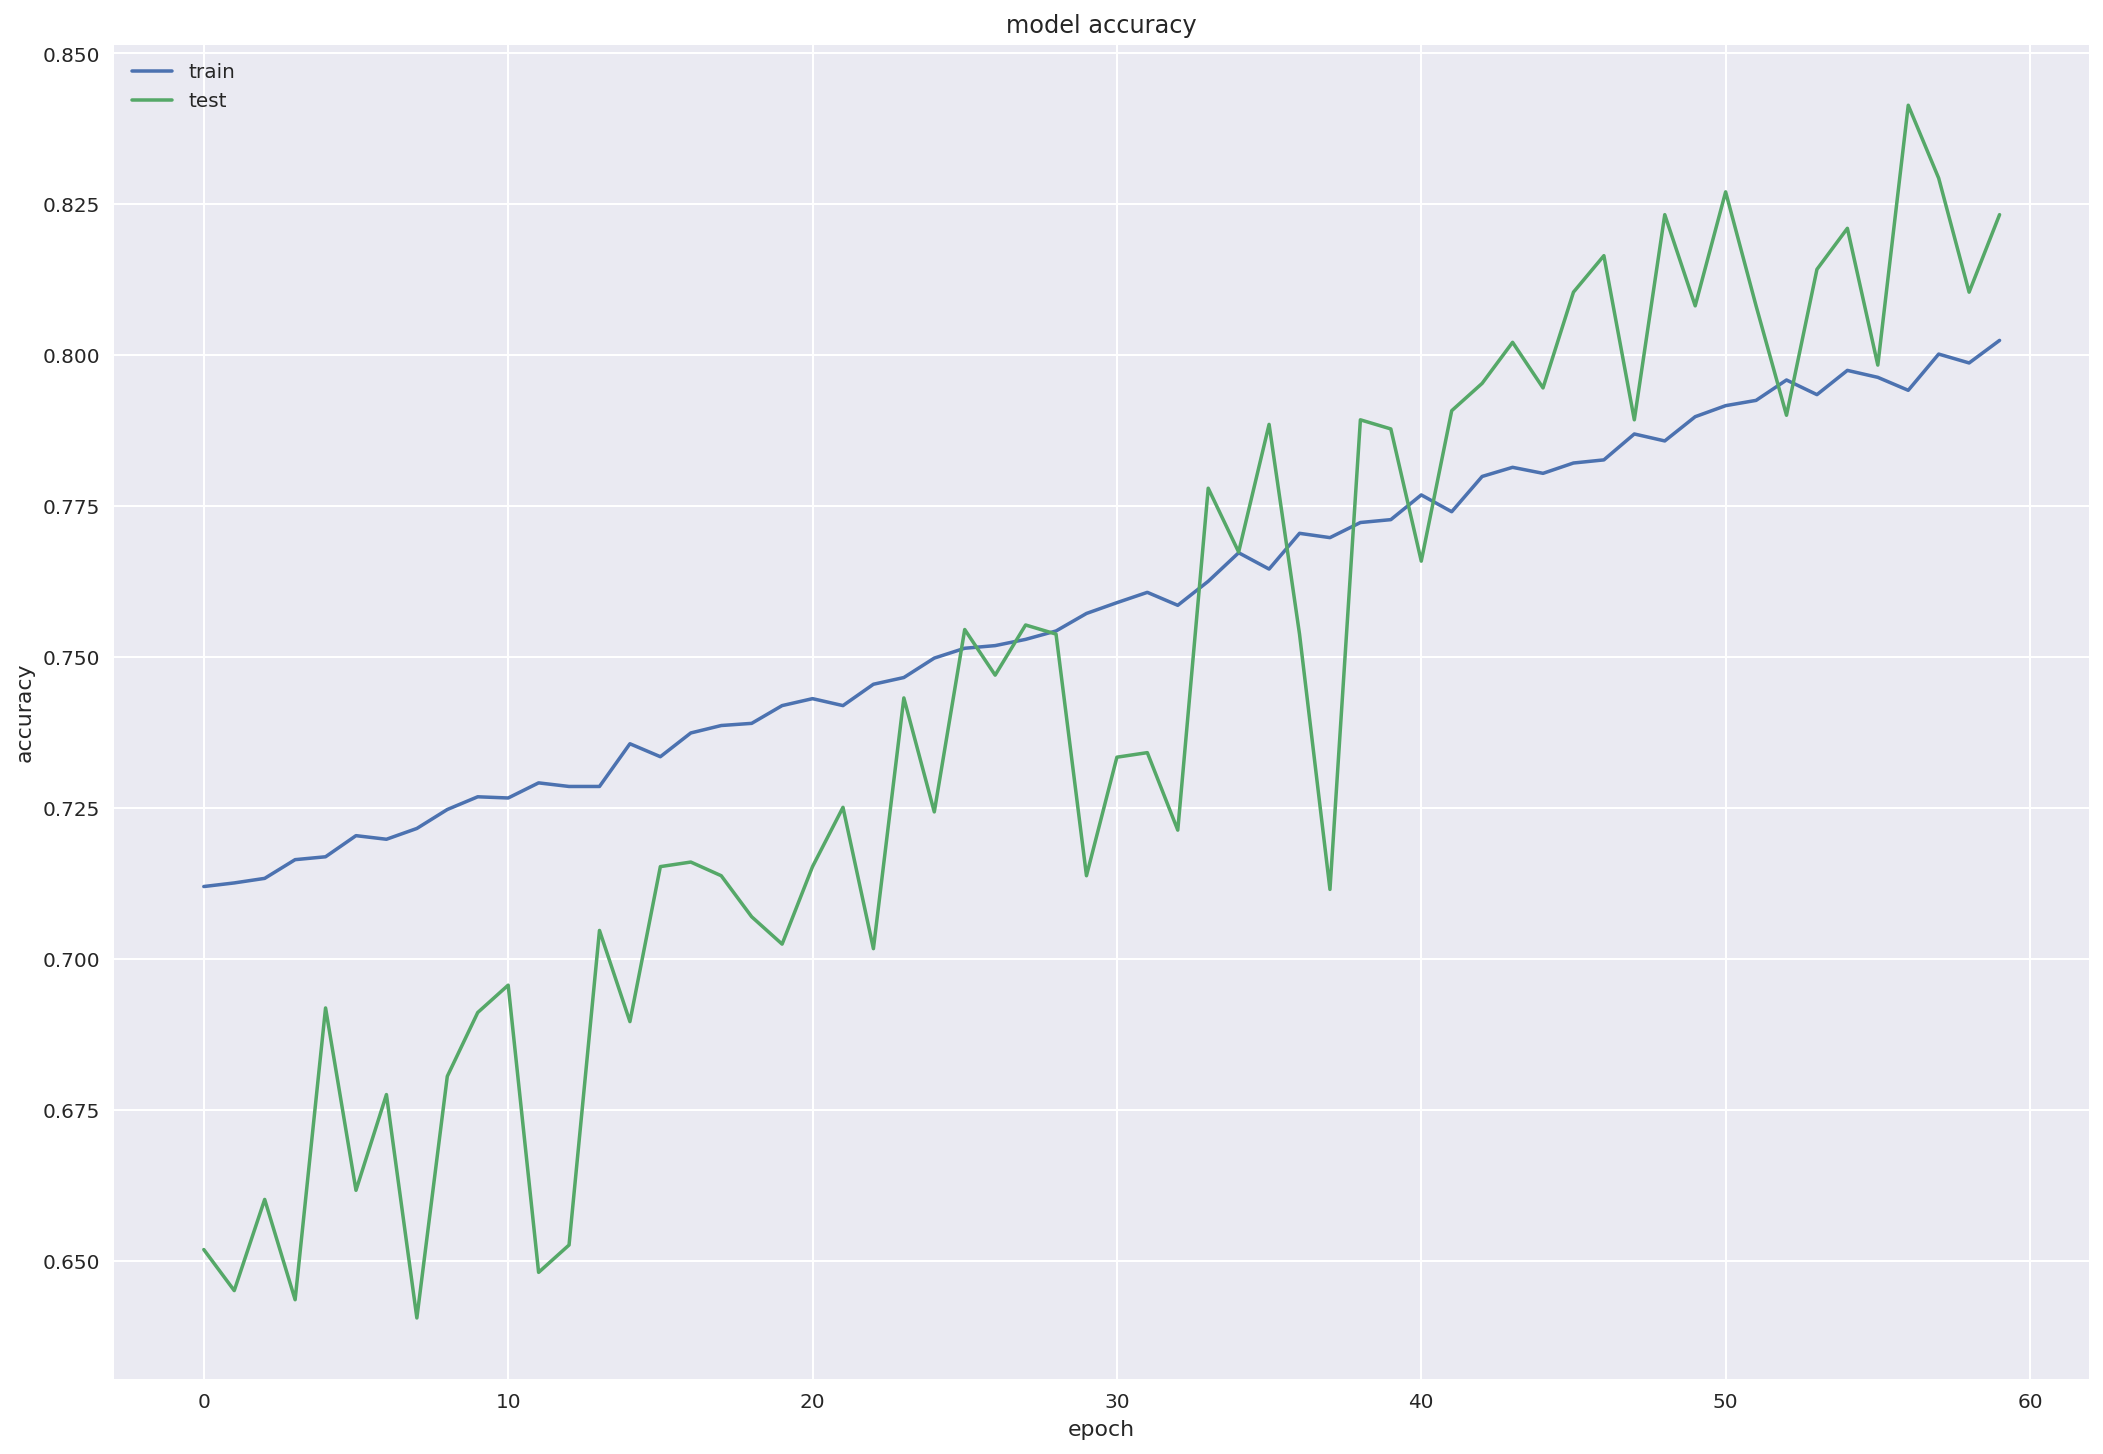

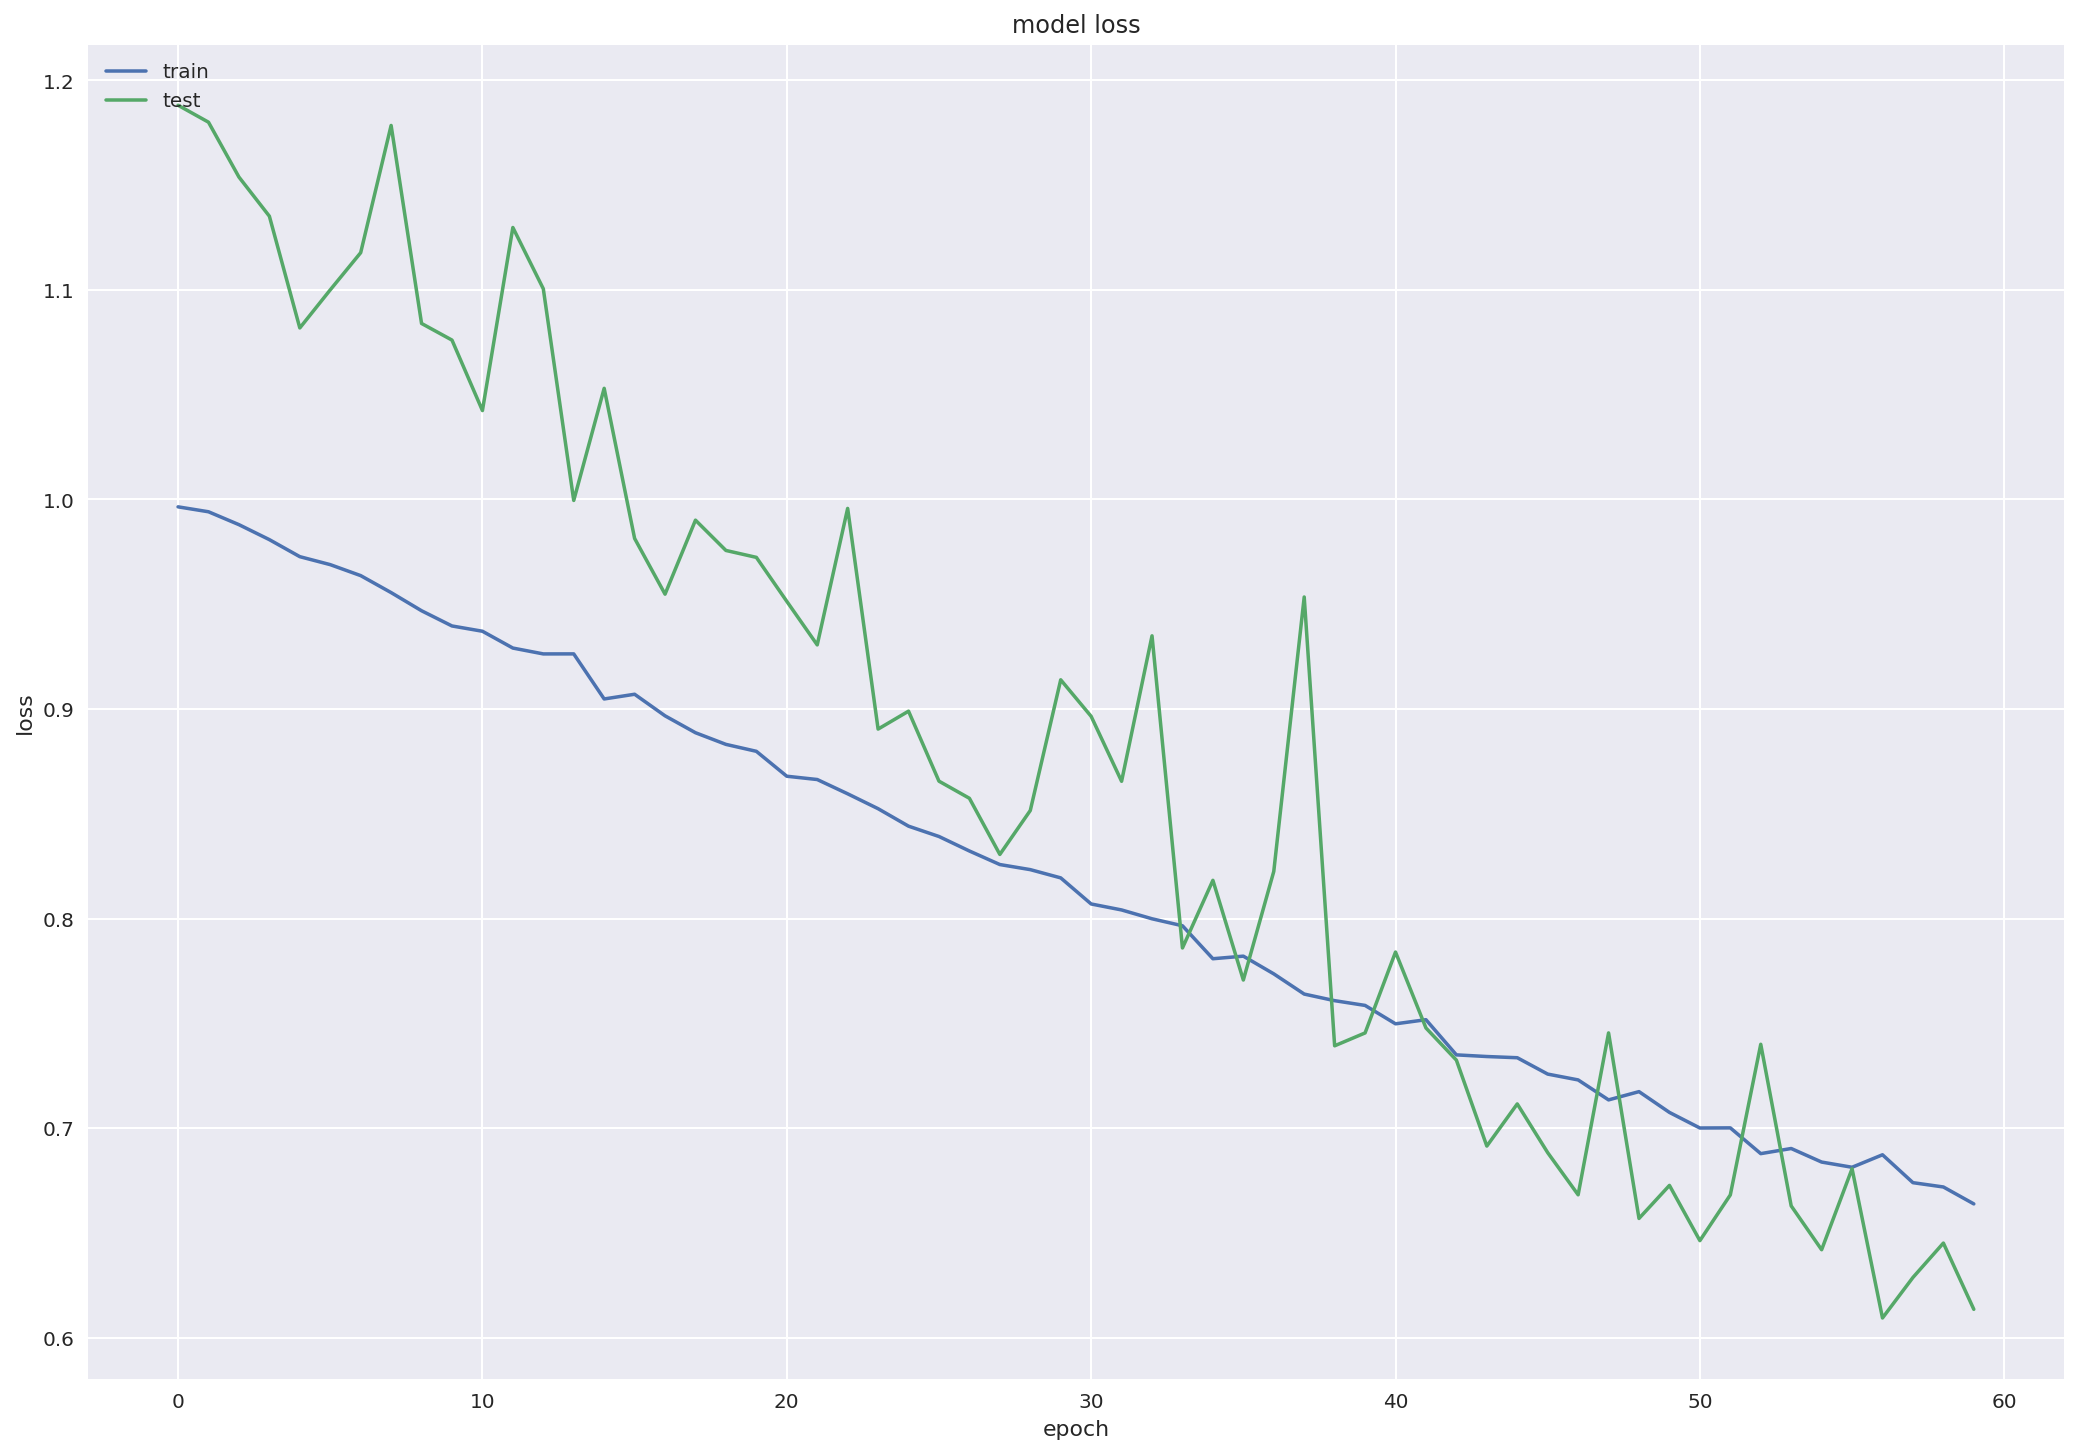

In [74]:
# Train implementing callbacks

import keras

# Implementing callbacks to save model after each epoch, just in case not used by now cholo
savepath = "weights-stage-{epoch:02d}-{loss:.4f}-model.hdf5"    
checkpoint = keras.callbacks.ModelCheckpoint(
    savepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     
history = modeld.fit(ninput, noutput, epochs=60, batch_size=512, validation_split=0.05)
scores = modeld.evaluate(ninput,noutput)

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#Save the model for duration
from keras.models import load_model

modeld.save('automusicDuration_model.h5')  # creates a HDF5 file 'my_model.h5'

---

---


# Create the song via predictions to the notes and duration model

In [366]:
import numpy as np
# Create the song with number of notes as specified in gnotes
gnotes = 400
songoutput = []
duraoutput = []
# Create starting numpy sequences for predicting notes and duration
#let's get a random index of the input sequences, for example:

#start = numpy.random.randint(0, len(ninput)-1)
#print("Random: ", start)
#seed = ninputclean[start]

print(reversedurationdict)


#seeds of inital For The Love of God sequence durantion and notes.
seed = np.array([12, 27, 2, 13, 38, 28, 13])
seedd = np.array([4, 4, 4, 49, 4, 4, 23])
print("Inital seed for notes: ",seed) 


# Create reverse dictionary to make the translation from int to notes and duration
reversenotedict = dict((number, note) for number, note in enumerate(allnotes))
reversedurationdict = dict((number, duration) for number, duration in enumerate(allduration))


#insert the seed as part of the song and as part of the duration
# we want to "force" to a similar Em start as with Vai's For the love of god

for i in range(7):
    result = reversenotedict[seed[i]]
    songoutput.append(result)

for i in range(7):
    result = reversedurationdict[seedd[i]]
    duraoutput.append(result)


# Get the notes

loops = 0

for note_index in range(gnotes):
    prediction_input = numpy.reshape(seed, (1, len(seed), 1))
    prediction_input = prediction_input / float(vocab)
    prediction = model.predict(prediction_input, verbose=0)

  
        

# get the max. prob result in the output to reverse find the note
    ix = numpy.argmax(prediction)
    result = reversenotedict[ix]
    
# Let's avoid tonic notes on scale to get too present

    if  (len(songoutput) > 3 ): 
        if (result == songoutput[-2]):
            loops = loops + 1
            if (loops == 6):
                #Choose a random note of th dict
                rdnote = numpy.random.randint(0,vocab)
                result = reversenotedict[rdnote]
                loops = 0

# Write the notes
    print("Predicted: ", ix,"--",result)
    songoutput.append(result)


    
    
    
# Here slide the window on the seed to create a new seed with 10, including the last predicted note
    print("Seed before: ", seed)
    seed = np.append(seed,ix)
    print("Append: ", seed)
    seed = seed[1:len(seed)]
    print("Seed Window: ",seed)

print("SONG OUTPUT: ", songoutput)
print("=================================")
print("")




{0: '0.0', 1: '0.25', 2: '0.5', 3: '0.75', 4: '1.0', 5: '1.25', 6: '1.5', 7: '1.75', 8: '1/3', 9: '10.0', 10: '10.5', 11: '10/3', 12: '11.0', 13: '11/3', 14: '12.0', 15: '12.5', 16: '13.0', 17: '13/3', 18: '14.0', 19: '15.5', 20: '15.75', 21: '16.0', 22: '17/3', 23: '2.0', 24: '2.25', 25: '2.5', 26: '2.75', 27: '2/3', 28: '20.0', 29: '20.5', 30: '23/3', 31: '25/3', 32: '3.0', 33: '3.25', 34: '3.5', 35: '3.75', 36: '31/3', 37: '32.0', 38: '4.0', 39: '4.25', 40: '4.5', 41: '4.75', 42: '4/3', 43: '5.0', 44: '5.25', 45: '5.5', 46: '5.75', 47: '5/3', 48: '6.0', 49: '6.5', 50: '7.0', 51: '7.5', 52: '7.75', 53: '7/3', 54: '8.0', 55: '8/3', 56: '9.5'}
Inital seed for notes:  [12 27  2 13 38 28 13]
Predicted:  56 -- G4
Seed before:  [12 27  2 13 38 28 13]
Append:  [12 27  2 13 38 28 13 56]
Seed Window:  [27  2 13 38 28 13 56]
Predicted:  13 -- B4
Seed before:  [27  2 13 38 28 13 56]
Append:  [27  2 13 38 28 13 56 13]
Seed Window:  [ 2 13 38 28 13 56 13]
Predicted:  28 -- D5
Seed before:  [ 2 13

Predicted:  13 -- B4
Seed before:  [ 2  2 13 38 28 13 56]
Append:  [ 2  2 13 38 28 13 56 13]
Seed Window:  [ 2 13 38 28 13 56 13]
Predicted:  28 -- D5
Seed before:  [ 2 13 38 28 13 56 13]
Append:  [ 2 13 38 28 13 56 13 28]
Seed Window:  [13 38 28 13 56 13 28]
Predicted:  2 -- A4
Seed before:  [13 38 28 13 56 13 28]
Append:  [13 38 28 13 56 13 28  2]
Seed Window:  [38 28 13 56 13 28  2]
Predicted:  2 -- A4
Seed before:  [38 28 13 56 13 28  2]
Append:  [38 28 13 56 13 28  2  2]
Seed Window:  [28 13 56 13 28  2  2]
Predicted:  12 -- B3
Seed before:  [28 13 56 13 28  2  2]
Append:  [28 13 56 13 28  2  2 12]
Seed Window:  [13 56 13 28  2  2 12]
Predicted:  2 -- D2
Seed before:  [13 56 13 28  2  2 12]
Append:  [13 56 13 28  2  2 12  2]
Seed Window:  [56 13 28  2  2 12  2]
Predicted:  2 -- A4
Seed before:  [56 13 28  2  2 12  2]
Append:  [56 13 28  2  2 12  2  2]
Seed Window:  [13 28  2  2 12  2  2]
Predicted:  13 -- B4
Seed before:  [13 28  2  2 12  2  2]
Append:  [13 28  2  2 12  2  2 13]
S

Predicted:  28 -- D5
Seed before:  [ 2  2 12  2  2 13 38]
Append:  [ 2  2 12  2  2 13 38 28]
Seed Window:  [ 2 12  2  2 13 38 28]
Predicted:  13 -- B4
Seed before:  [ 2 12  2  2 13 38 28]
Append:  [ 2 12  2  2 13 38 28 13]
Seed Window:  [12  2  2 13 38 28 13]
Predicted:  56 -- G4
Seed before:  [12  2  2 13 38 28 13]
Append:  [12  2  2 13 38 28 13 56]
Seed Window:  [ 2  2 13 38 28 13 56]
Predicted:  13 -- B4
Seed before:  [ 2  2 13 38 28 13 56]
Append:  [ 2  2 13 38 28 13 56 13]
Seed Window:  [ 2 13 38 28 13 56 13]
Predicted:  28 -- D5
Seed before:  [ 2 13 38 28 13 56 13]
Append:  [ 2 13 38 28 13 56 13 28]
Seed Window:  [13 38 28 13 56 13 28]
Predicted:  2 -- A4
Seed before:  [13 38 28 13 56 13 28]
Append:  [13 38 28 13 56 13 28  2]
Seed Window:  [38 28 13 56 13 28  2]
Predicted:  2 -- A4
Seed before:  [38 28 13 56 13 28  2]
Append:  [38 28 13 56 13 28  2  2]
Seed Window:  [28 13 56 13 28  2  2]
Predicted:  12 -- B3
Seed before:  [28 13 56 13 28  2  2]
Append:  [28 13 56 13 28  2  2 12]

Predicted:  13 -- B4
Seed before:  [13 28  2  2 12  2  2]
Append:  [13 28  2  2 12  2  2 13]
Seed Window:  [28  2  2 12  2  2 13]
Predicted:  38 -- E5
Seed before:  [28  2  2 12  2  2 13]
Append:  [28  2  2 12  2  2 13 38]
Seed Window:  [ 2  2 12  2  2 13 38]
Predicted:  28 -- D5
Seed before:  [ 2  2 12  2  2 13 38]
Append:  [ 2  2 12  2  2 13 38 28]
Seed Window:  [ 2 12  2  2 13 38 28]
Predicted:  13 -- B4
Seed before:  [ 2 12  2  2 13 38 28]
Append:  [ 2 12  2  2 13 38 28 13]
Seed Window:  [12  2  2 13 38 28 13]
Predicted:  56 -- G4
Seed before:  [12  2  2 13 38 28 13]
Append:  [12  2  2 13 38 28 13 56]
Seed Window:  [ 2  2 13 38 28 13 56]
Predicted:  13 -- B4
Seed before:  [ 2  2 13 38 28 13 56]
Append:  [ 2  2 13 38 28 13 56 13]
Seed Window:  [ 2 13 38 28 13 56 13]
Predicted:  28 -- D5
Seed before:  [ 2 13 38 28 13 56 13]
Append:  [ 2 13 38 28 13 56 13 28]
Seed Window:  [13 38 28 13 56 13 28]
Predicted:  2 -- A4
Seed before:  [13 38 28 13 56 13 28]
Append:  [13 38 28 13 56 13 28  2

Predicted:  2 -- A4
Seed before:  [56 13 28  2  2 12  2]
Append:  [56 13 28  2  2 12  2  2]
Seed Window:  [13 28  2  2 12  2  2]
Predicted:  13 -- B4
Seed before:  [13 28  2  2 12  2  2]
Append:  [13 28  2  2 12  2  2 13]
Seed Window:  [28  2  2 12  2  2 13]
Predicted:  38 -- E5
Seed before:  [28  2  2 12  2  2 13]
Append:  [28  2  2 12  2  2 13 38]
Seed Window:  [ 2  2 12  2  2 13 38]
Predicted:  28 -- D5
Seed before:  [ 2  2 12  2  2 13 38]
Append:  [ 2  2 12  2  2 13 38 28]
Seed Window:  [ 2 12  2  2 13 38 28]
Predicted:  13 -- B4
Seed before:  [ 2 12  2  2 13 38 28]
Append:  [ 2 12  2  2 13 38 28 13]
Seed Window:  [12  2  2 13 38 28 13]
Predicted:  56 -- G4
Seed before:  [12  2  2 13 38 28 13]
Append:  [12  2  2 13 38 28 13 56]
Seed Window:  [ 2  2 13 38 28 13 56]
Predicted:  13 -- B4
Seed before:  [ 2  2 13 38 28 13 56]
Append:  [ 2  2 13 38 28 13 56 13]
Seed Window:  [ 2 13 38 28 13 56 13]
Predicted:  28 -- D5
Seed before:  [ 2 13 38 28 13 56 13]
Append:  [ 2 13 38 28 13 56 13 28

Predicted:  12 -- B3
Seed before:  [28 13 56 13 28  2  2]
Append:  [28 13 56 13 28  2  2 12]
Seed Window:  [13 56 13 28  2  2 12]
Predicted:  2 -- A4
Seed before:  [13 56 13 28  2  2 12]
Append:  [13 56 13 28  2  2 12  2]
Seed Window:  [56 13 28  2  2 12  2]
Predicted:  2 -- A4
Seed before:  [56 13 28  2  2 12  2]
Append:  [56 13 28  2  2 12  2  2]
Seed Window:  [13 28  2  2 12  2  2]
Predicted:  13 -- B4
Seed before:  [13 28  2  2 12  2  2]
Append:  [13 28  2  2 12  2  2 13]
Seed Window:  [28  2  2 12  2  2 13]
Predicted:  38 -- E5
Seed before:  [28  2  2 12  2  2 13]
Append:  [28  2  2 12  2  2 13 38]
Seed Window:  [ 2  2 12  2  2 13 38]
Predicted:  28 -- D5
Seed before:  [ 2  2 12  2  2 13 38]
Append:  [ 2  2 12  2  2 13 38 28]
Seed Window:  [ 2 12  2  2 13 38 28]
Predicted:  13 -- B4
Seed before:  [ 2 12  2  2 13 38 28]
Append:  [ 2 12  2  2 13 38 28 13]
Seed Window:  [12  2  2 13 38 28 13]
Predicted:  56 -- G4
Seed before:  [12  2  2 13 38 28 13]
Append:  [12  2  2 13 38 28 13 56]

In [369]:

#NOW Let's get inferences on duration

# Get the duration


for note_index in range(gnotes):
    prediction_input = numpy.reshape(seedd, (1, len(seedd), 1))
    prediction_input = prediction_input / float(vocabd)
    prediction = modeld.predict(prediction_input, verbose=0)
    

# get the max. prob result in the output to reverse find the note
# For this demo, trim high duration notes (/4) and 0 duration, as they sound like chords

    ix = numpy.argmax(prediction)
    
    if ix > 4:
        ix = ix / 4
    if (ix  == 0) or (ix == 1):
        ix = numpy.random.randint(1,vocabd)
    if ix > 4:
        ix = ix / 4
        
    result = reversedurationdict[int(ix)]
    
# Let's avoid tonic notes on scale to get too present

    if  (len(duraoutput) > 3 ): 
        if (result == duraoutput[-2]):
            loops = loops + 1
            if (loops == 3):
                #Choose a random note of the dict
                rddura = numpy.random.randint(1,vocab)
                result = reversedurationdict[rddura]
                loops = 0
                ix = rddura
    

# Add to the duration output
    duraoutput.append(result)
    
# Here slide the window on the seed to create a new seed with 10, including the last predicted note
    seedd = np.append(seedd,ix)
    seedd = seedd[1:len(seedd)]
    
print("DURATION GENERATED: ",duraoutput)

DURATION GENERATED:  ['1.0', '1.0', '1.0', '6.5', '1.0', '1.0', '2.0', '0.75', '0.75', '1.0', '1.0', '1.0', '0.25', '1/3', '0.5', '10/3', '5.25', '1.0', '1.0', '1/3', '0.25', '0.5', '0.5', '0.5', '0.5', '20.0', '10.5', '0.5', '0.5', '0.5', '0.5', '3.5', '1.0', '1.75', '1.0', '1.0', '0.5', '0.5', '0.5', '3.0', '0.5', '0.5', '1.0', '0.5', '0.5', '6.5', '0.5', '0.25', '0.5', '0.5', '11.0', '12.0', '0.5', '1.25', '7.75', '0.25', '0.25', '11.0', '1/3', '0.5', '11/3', '11.0', '0.5', '0.5', '0.5', '10.0', '10.0', '0.5', '0.5', '0.5', '10.5', '1.0', '1.0', '1/3', '0.5', '0.5', '0.5', '0.5', '10/3', '0.5', '10.5', '0.5', '0.5', '3.0', '10.5', '0.25', '1.0', '1.75', '0.25', '0.5', '0.5', '0.5', '0.5', '4.0', '11.0', '10/3', '0.5', '0.25', '0.5', '0.5', '0.5', '2.75', '10/3', '11.0', '0.5', '11/3', '0.5', '0.5', '0.5', '1.5', '1.75', '10/3', '0.5', '0.5', '11.0', '0.25', '0.5', '0.5', '0.5', '0.5', '0.75', '0.75', '0.5', '0.5', '0.5', '0.5', '7/3', '0.5', '0.25', '0.25', '1.75', '1/3', '0.5', '1.

## Build the song with the notes and duration predicted

In [370]:
import music21
from music21 import instrument

finalsong = []

for element in range(gnotes):
    print("metiendo a nota: ",songoutput[element])
    loopnote = note.Note(songoutput[element])
    loopnote.storedInstrument = instrument.Guitar()
 
    print("metiendo a duracion: ",duraoutput[element])
    #if it is fraction, fix to the music21 format
    if "/" in duraoutput[element]:
        print("TRIPE; ",type(duraoutput[element]))
        x = str(duraoutput[element]).split('/')
        duraoutput[element] = int(x[0]) / int(x[1])
        print("DIVIDeD: ",duraoutput[element])
   
    
    #loopnote.quarterLength = float(2.0/3)
    
    loopnote.quarterLength = float(duraoutput[element])
    finalsong.append(loopnote)


metiendo a nota:  B3
metiendo a duracion:  1.0
metiendo a nota:  D4
metiendo a duracion:  1.0
metiendo a nota:  A4
metiendo a duracion:  1.0
metiendo a nota:  B4
metiendo a duracion:  6.5
metiendo a nota:  E5
metiendo a duracion:  1.0
metiendo a nota:  D5
metiendo a duracion:  1.0
metiendo a nota:  B4
metiendo a duracion:  2.0
metiendo a nota:  G4
metiendo a duracion:  0.75
metiendo a nota:  B4
metiendo a duracion:  0.75
metiendo a nota:  D5
metiendo a duracion:  1.0
metiendo a nota:  A4
metiendo a duracion:  1.0
metiendo a nota:  A4
metiendo a duracion:  1.0
metiendo a nota:  B3
metiendo a duracion:  0.25
metiendo a nota:  A4
metiendo a duracion:  1/3
TRIPE;  <class 'str'>
DIVIDeD:  0.3333333333333333
metiendo a nota:  A4
metiendo a duracion:  0.5
metiendo a nota:  B4
metiendo a duracion:  10/3
TRIPE;  <class 'str'>
DIVIDeD:  3.3333333333333335
metiendo a nota:  E5
metiendo a duracion:  5.25
metiendo a nota:  D5
metiendo a duracion:  1.0
metiendo a nota:  B4
metiendo a duracion:  1.0


# Put all inside a Midi stream in Music21

In [371]:
# Extract the parts from For the Love of God to add its backing track to the generated melody

import glob
from music21 import converter, instrument, note, chord, midi
 
#midi_path= "ForTheLoveofGod.mid"
midi_path= "MIDI/FTLOG.mid"

notes = []
chords = []
duration = []
notes_to_parse = None

for file in glob.glob(midi_path):
    print("--------------------------------------------")
    print("Reading midi file: ", file)
#Read MIDI

    mf = midi.MidiFile()
    mf.open(file)
    mf.read()
    mf.close()
    
#List song parts
    midix = midi.translate.midiFileToStream(mf)
    partStream = midix.parts.stream()
    print("List of instruments found on MIDI file: ",file)
    for p in partStream:
        aux = p
        print (p.partName)

#info about the song

    parts = midix.parts.stream()
    print("PARTS: ",parts.parts[1])

    print("Elements of the MIDI: ",midix.elements)
    print("Parts of the MIDI: ",parts)
    print("LEN parts:", len(parts))

#extracting the melody part 

    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes flat structure
        notes_to_parse = midi.flat.notes


#parse notes,duration an chords


--------------------------------------------
Reading midi file:  MIDI/FTLOG.mid
List of instruments found on MIDI file:  MIDI/FTLOG.mid
None
Sitar
Piano
None
PARTS:  <music21.stream.Part 0x7f3367254668>
Elements of the MIDI:  (<music21.stream.Part 0x7f3367c5bac8>, <music21.stream.Part 0x7f3367254668>, <music21.stream.Part 0x7f33661a3e80>, <music21.stream.Part 0x7f33663a5ef0>)
Parts of the MIDI:  <music21.stream.Score 0x7f3366fbe160>
LEN parts: 4


In [372]:
from music21 import stream, instrument

part = stream.Part()
part.append(finalsong)
part.insert(0, instrument.Sitar())

Songg = stream.Score()
Songg.insert(0, part)


p1 = stream.Part(id='Piano')
p1 = parts[1]

p3 = stream.Part(id='Drums')
p3 = parts[3]


Songg.insert(1,p1)
Songg.insert(2,parts[2])
Songg.insert(3,p3)

Songg.write('midi', fp='R3-Automusic.mid')
#output_st = stream.Stream(finalsong)
#output_st.write('midi', fp='test_output.mid')



 

'R3-Automusic.mid'

In [97]:
#12 12  0 22  1  1  1
seed = np.array([12, 12, 0, 22,1,1,1])
prediction_input = numpy.reshape(seed, (1, len(seed), 1))
prediction = modeld.predict(prediction_input, verbose=1)
ix = numpy.argmax(prediction)
print(ix)

1/1 [==============================] - 0s 10ms/step
27
